## Assignment 2: Network Safety


#### CSC 180  Intelligent Systems (Spring 2020)

#### Ace English

# Helpful Functions for Tensorflow

In [1]:
from collections.abc import Sequence
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import svm, datasets
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import random


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)
    

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)
    
    
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# Visualizing data


## Read data

In [2]:
#define datatypes for readability later
datatype={}

datatype["duration"] = "continuous"
datatype["protocol_type"] = "symbolic"
datatype["service"] = "symbolic"
datatype["flag"] = "symbolic"
datatype["src_bytes"] = "continuous"
datatype["dst_bytes"] = "continuous"
datatype["land"] = "symbolic"
datatype["wrong_fragment"] = "continuous"
datatype["urgent"] = "continuous"
datatype["hot"] = "continuous"
datatype["num_failed_logins"] = "continuous"
datatype["logged_in"] = "symbolic"
datatype["num_compromised"] = "continuous"
datatype["root_shell"] = "continuous"
datatype["su_attempted"] = "continuous"
datatype["num_root"] = "continuous"
datatype["num_file_creations"] = "continuous"
datatype["num_shells"] = "continuous"
datatype["num_access_files"] = "continuous"
datatype["num_outbound_cmds"] = "continuous"
datatype["is_host_login"] = "symbolic"
datatype["is_guest_login"] = "symbolic"
datatype["count"] = "continuous"
datatype["srv_count"] = "continuous"
datatype["serror_rate"] = "continuous"
datatype["srv_serror_rate"] = "continuous"
datatype["rerror_rate"] = "continuous"
datatype["srv_rerror_rate"] = "continuous"
datatype["same_srv_rate"] = "continuous"
datatype["diff_srv_rate"] = "continuous"
datatype["srv_diff_host_rate"] = "continuous"
datatype["dst_host_count"] = "continuous"
datatype["dst_host_srv_count"] = "continuous"
datatype["dst_host_same_srv_rate"] = "continuous"
datatype["dst_host_diff_srv_rate"] = "continuous"
datatype["dst_host_same_src_port_rate"] = "continuous"
datatype["dst_host_srv_diff_host_rate"] = "continuous"
datatype["dst_host_serror_rate"] = "continuous"
datatype["dst_host_srv_serror_rate"] = "continuous"
datatype["dst_host_rerror_rate"] = "continuous"
datatype["dst_host_srv_rerror_rate"] = "continuous"
datatype["outcome"] = "symbolic"


df = pd.read_csv("network_intrusion_data.csv")

#assign columns
df.columns = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome']

df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494015,0,tcp,http,SF,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494016,0,tcp,http,SF,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,tcp,http,SF,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494018,0,tcp,http,SF,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


# Data Examination
Now we clean the data. Part of this process is checking for redundant records and records with missing values. Like normal, we will encode categorical data and normalizing numerical data.

First we want to search for duplicates and remove them. Then we want to see what kind of sample sizes we can work with which each of these, so instead of just returning each list I want to produce a count.


In [3]:
df_dupes=df[df.duplicated()]
print ("Removing ",df_dupes.shape[0]," duplicate entries...")
df_unique=df.drop_duplicates()

#view all values
for (colName, colData) in df_unique.iteritems():
    valueCount=colData.drop_duplicates()
    print(colName, "-",valueCount.size, valueCount.values)

#check values count
i=0
for (colName, colData) in df_unique.iteritems():
    value_counts=colData.value_counts();
    print("Name: ",colName," Type: ",list(datatype)[i], "Size:", value_counts.size)
    print(value_counts.sort_values(ascending=False))
    print()
    i=i+1

Removing  348435  duplicate entries...
duration - 2495 [   0    1   79 ... 2695 2751  120]
protocol_type - 3 ['tcp' 'udp' 'icmp']
service - 66 ['http' 'smtp' 'finger' 'domain_u' 'auth' 'telnet' 'ftp' 'eco_i' 'ntp_u'
 'ecr_i' 'other' 'private' 'pop_3' 'ftp_data' 'rje' 'time' 'mtp' 'link'
 'remote_job' 'gopher' 'ssh' 'name' 'whois' 'domain' 'login' 'imap4'
 'daytime' 'ctf' 'nntp' 'shell' 'IRC' 'nnsp' 'http_443' 'exec' 'printer'
 'efs' 'courier' 'uucp' 'klogin' 'kshell' 'echo' 'discard' 'systat'
 'supdup' 'iso_tsap' 'hostnames' 'csnet_ns' 'pop_2' 'sunrpc' 'uucp_path'
 'netbios_ns' 'netbios_ssn' 'netbios_dgm' 'sql_net' 'vmnet' 'bgp' 'Z39_50'
 'ldap' 'netstat' 'urh_i' 'X11' 'urp_i' 'pm_dump' 'tftp_u' 'tim_i' 'red_i']
flag - 11 ['SF' 'S1' 'REJ' 'S2' 'S0' 'S3' 'RSTO' 'RSTR' 'RSTOS0' 'OTH' 'SH']
src_bytes - 3300 [239 235 219 ... 500 484 475]
dst_bytes - 10725 [  486  1337  2032 ... 34557 10592 13828]
land - 2 [0 1]
wrong_fragment - 3 [0 1 3]
urgent - 4 [0 2 1 3]
hot - 22 [ 0  1  3 19  6  4 30 

Name:  flag  Type:  flag Size: 11
SF        87458
S0        42278
REJ       14712
RSTO        569
RSTR        425
S1           57
SH           34
S2           24
RSTOS0       11
S3           10
OTH           7
Name: flag, dtype: int64

Name:  src_bytes  Type:  src_bytes Size: 3300
0        57872
147       1962
105       1467
146       1454
42         941
         ...  
13545        1
5512         1
11370        1
92994        1
2047         1
Name: src_bytes, Length: 3300, dtype: int64

Name:  dst_bytes  Type:  dst_bytes Size: 10725
0        67663
105       3199
8314       899
330        854
329        804
         ...  
3210         1
4635         1
6682         1
11132        1
16584        1
Name: dst_bytes, Length: 10725, dtype: int64

Name:  land  Type:  land Size: 2
0    145565
1        20
Name: land, dtype: int64

Name:  wrong_fragment  Type:  wrong_fragment Size: 3
0    144464
3       910
1       211
Name: wrong_fragment, dtype: int64

Name:  urgent  Type:  urgent Size: 4
0    

0.00    124252
1.00     14039
0.01      1594
0.02       774
0.03       392
         ...  
0.26        19
0.34        18
0.46        15
0.39        14
0.79        13
Name: dst_host_rerror_rate, Length: 101, dtype: int64

Name:  dst_host_srv_rerror_rate  Type:  dst_host_srv_rerror_rate Size: 101
0.00    125255
1.00     13142
0.01      1849
0.02       625
0.04       377
         ...  
0.21         6
0.32         5
0.28         4
0.22         4
0.26         4
Name: dst_host_srv_rerror_rate, Length: 101, dtype: int64

Name:  outcome  Type:  outcome Size: 23
normal.             87831
neptune.            51820
back.                 968
teardrop.             918
satan.                906
warezclient.          893
ipsweep.              651
smurf.                641
portsweep.            416
pod.                  206
nmap.                 158
guess_passwd.          53
buffer_overflow.       30
warezmaster.           20
land.                  19
imap.                  12
rootkit.               10

All this data looks valid.

`num_outbound_cmds` and `is_host_login` both have only 1 entry type, so they can be dropped.

We also see that several of the fields have a huge disparity in volume. `urgent` is almost entirely 0. Several other fields have a huge majority of one field with other fields being rare. However, several of these may be crucial for finding attacks.


`wrong_fragment`, `num_failed_logins`, `num_compromised`, `hot`, `root_shell`, `su_attempted`, `num_root`, `num_file_creations`, `num_shells`, `is_guest_login`, `num_access_files`

## Separating attacks from normal
We will filter off the attacks from the normal dataspace to see if their representation makes more sense when looking at non-normal data.

In [4]:
#drop worthless data
df_unique=df_unique.drop(['is_host_login','num_outbound_cmds'], axis=1)

#remove rows with missing data
df_unique=df_unique.dropna()

outliers=['outcome','land','wrong_fragment', 'num_failed_logins', 'num_compromised', 'hot', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'is_guest_login', 'num_access_files']
df_normals=df_unique[df_unique['outcome']=='normal.']
df_attacks=df_unique.drop(df_normals.index)

i=0
for (colName, colData) in df_attacks.iteritems():
    if(colName in outliers):
        value_counts=colData.value_counts();
        print("Name: ",colName," Type: ",list(datatype)[i], "Size:", value_counts.size)
        print(value_counts.sort_values(ascending=False))
        print()
    i=i+1

Name:  land  Type:  land Size: 2
0    57735
1       19
Name: land, dtype: int64

Name:  wrong_fragment  Type:  wrong_fragment Size: 3
0    56633
3      910
1      211
Name: wrong_fragment, dtype: int64

Name:  hot  Type:  hot Size: 14
0     56339
2       917
28      274
1       133
3        34
5        16
4        15
20        9
6         8
19        5
7         1
10        1
15        1
18        1
Name: hot, dtype: int64

Name:  num_failed_logins  Type:  num_failed_logins Size: 3
0    57701
1       52
5        1
Name: num_failed_logins, dtype: int64

Name:  num_compromised  Type:  num_compromised Size: 10
0     56832
1       901
2         8
4         7
3         1
5         1
6         1
38        1
16        1
22        1
Name: num_compromised, dtype: int64

Name:  root_shell  Type:  root_shell Size: 2
0    57722
1       32
Name: root_shell, dtype: int64

Name:  su_attempted  Type:  su_attempted Size: 2
0    57753
1        1
Name: su_attempted, dtype: int64

Name:  num_root  Type:  

Surprisingly a lot of these values are still disproportionate even among errors only. Many of them will get dropped later.

`num_failed_logins`,`root_shell`,`su_attempted`,`num_root`, `num_file_creations`,`num_shells`, `num_access_files` seem irrelevent and have very little data to go off of.

## Data prep
Next I'm going to format the arrays in a useful way. To encode output as safe/unsafe, I will add another layer "attack" and drop the layer "outcome" (I supsect the neural network will rely too heavily on it if I leave it in.)

I am also going to apply **downsampling** here so that the quantity of good connections more closely matches the volume of attacks.

### Normalization and one-hot encoding

For `outcome` we don't care what the error code is (just that it is not normal), thus we went to one-hot encode for 2 values - normal and attack. After normalization columns may get dropped because the values are not significant enough to be nonzero. This is fine.

In [5]:
drop_columns=['urgent','land','num_failed_logins', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 
              'num_shells', 'num_access_files']
#Model using fewer of the good samples - same number as most common error
df_downsampled=df_normals.sample(51820).append(df_attacks)
#model dropping rows that might be irrelevent
df_slim=df_unique.drop(drop_columns,axis=1)
#model dropping irrelevent rows AND using downsampling
df_slim_downsampled=df_downsampled.drop(drop_columns,axis=1)
#use 10% of data for model
df_sample=df_slim_downsampled.sample(frac=0.1)


#map for encoding
def make_binary(string):
    if(string=="normal."):
        return 0
    else:
        return 1

#encode y
y=df_sample["outcome"].map(make_binary)
#y_test_model=df_slim["outcome"].map(make_binary)
print(y)

y_one_hot = tf.keras.utils.to_categorical(y, 2)

print(y_one_hot)
#get arrays for training

x=df_sample.drop(["outcome"], axis=1)


#prep for model
for (name,column) in x.iteritems():
    if(datatype[name]=='continuous'):
        encode_numeric_zscore(x, name)
    else:
        encode_text_dummy(x,name)

 # Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42) 


374814    1
470680    1
87189     0
351432    1
139112    0
         ..
149827    1
345762    0
392561    1
357134    1
375330    1
Name: outcome, Length: 10957, dtype: int64
[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


After data prep some colums may now have no different values in them, in essence the rare values to a general majority may have been entirely dropped so the one-hot encoded label is now empty.

## Model training and testing
> Debugging by hand is like trying to find tiny holes in a dartboard covered in cloth...and you only have 5 darts.


To compare models, we are comparing the **accuracy, recall, precision** and **F1** score. For each type of model we will test different variable weights.
## Fully connected Neural Network
- Activation: **relu**, **sigmoid**, **tanh**
- **Layer count**
- **Neuron count**
- Optimizer: **Adam**, **SGC**

In [6]:
def test_model(y_test, pred):
    pred = np.argmax(pred,axis=1)
    print(pred)
    y_true = np.argmax(y_test,axis=1)
    print(pred)
    cm = confusion_matrix(y_test, pred)
    print(cm)


    labels=["good","attack"]
    plt.figure()
    plot_confusion_matrix(cm, labels)
    plt.show()
    

    print(classification_report(y_test, pred))
    plot_roc(pred,y_test)

In [7]:
def test_nn(activation, num_layers, num_neurons, optimizer, x_train,y_train,x_test,y_test):
    print("Fully connected neural network")
    print("Activation:",activation,"Number of layers: ",num_layers+2,"Number of neurons:",num_neurons,"Optimizer:",optimizer)

   # Build network
    model = Sequential()
    model.add(Dense(num_neurons, input_dim=x_train.shape[1], activation=activation))
    #model.add(Dense(num_neurons, input_dim=2, activation=activation))
    current=num_neurons
    interval=num_neurons/(num_layers+1)
    for i in range(num_layers):
        current=current-interval
        model.add(Dense(current, activation=activation))
        
    model.add(Dense(y_train.size, activation='softmax'))
        
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')  
    model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], verbose=2, epochs=1000)
    
    #test model
    pred = model.predict(x_test)
    print(pred)
    test_model(y_test, pred)
    
    return model
    



Fully connected neural network
Activation: relu Number of layers:  3 Number of neurons: 100 Optimizer: adam
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 3s - loss: 1.2489 - val_loss: 0.0327
Epoch 2/1000
8217/8217 - 3s - loss: 0.0241 - val_loss: 0.0265
Epoch 3/1000
8217/8217 - 2s - loss: 0.0202 - val_loss: 0.0205
Epoch 4/1000
8217/8217 - 3s - loss: 0.0188 - val_loss: 0.0198
Epoch 5/1000
8217/8217 - 3s - loss: 0.0146 - val_loss: 0.0196
Epoch 00005: early stopping
[[9.99898195e-01 1.00596582e-04 2.06797524e-10 ... 3.68704983e-10
  1.88826801e-10 1.14049034e-10]
 [9.76892233e-01 2.31024176e-02 9.53828794e-10 ... 1.86337146e-09
  7.84246446e-10 4.83403595e-10]
 [1.01722571e-05 9.99989867e-01 2.31270103e-12 ... 5.05963804e-12
  2.14293709e-12 1.37181998e-12]
 ...
 [9.99899864e-01 9.92161877e-05 1.56099828e-10 ... 2.82887852e-10
  1.43048656e-10 8.52922663e-11]
 [6.52452436e-05 9.99933600e-01 1.54513471e-10 ... 2.95569430e-10
  1.45328971e-10 9.65009878e-11]
 [2.99

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


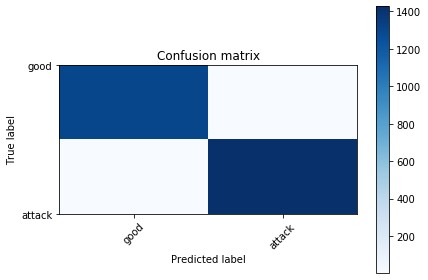

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1305
           1       1.00      0.99      1.00      1435

    accuracy                           1.00      2740
   macro avg       1.00      1.00      1.00      2740
weighted avg       1.00      1.00      1.00      2740



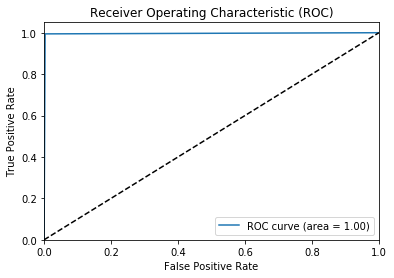

In [27]:
test_nn('relu',1,100,'adam',x_train,y_train,x_test,y_test)

Fully connected neural network
Activation: relu Number of layers:  3 Number of neurons: 100 Optimizer: adam
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 3s - loss: 1.2479 - val_loss: 0.0294
Epoch 2/1000
8217/8217 - 3s - loss: 0.0251 - val_loss: 0.0211
Epoch 3/1000
8217/8217 - 3s - loss: 0.0197 - val_loss: 0.0199
Epoch 4/1000
8217/8217 - 3s - loss: 0.0172 - val_loss: 0.0197
Epoch 5/1000
8217/8217 - 3s - loss: 0.0150 - val_loss: 0.0185
Epoch 6/1000
8217/8217 - 3s - loss: 0.0140 - val_loss: 0.0194
Epoch 7/1000
8217/8217 - 3s - loss: 0.0130 - val_loss: 0.0173
Epoch 8/1000
8217/8217 - 3s - loss: 0.0119 - val_loss: 0.0168
Epoch 9/1000
8217/8217 - 3s - loss: 0.0127 - val_loss: 0.0159
Epoch 10/1000
8217/8217 - 3s - loss: 0.0096 - val_loss: 0.0145
Epoch 11/1000
8217/8217 - 3s - loss: 0.0096 - val_loss: 0.0137
Epoch 12/1000
8217/8217 - 2s - loss: 0.0084 - val_loss: 0.0146
Epoch 00012: early stopping
[[9.9968791e-01 3.1199169e-04 2.0789913e-11 ... 2.8758541e-11
  2.398

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


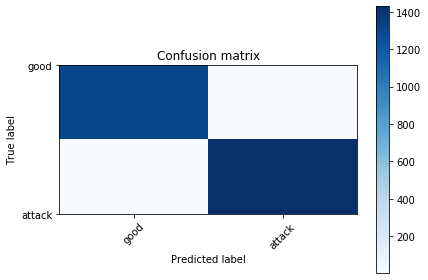

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1305
           1       1.00      1.00      1.00      1435

    accuracy                           1.00      2740
   macro avg       1.00      1.00      1.00      2740
weighted avg       1.00      1.00      1.00      2740



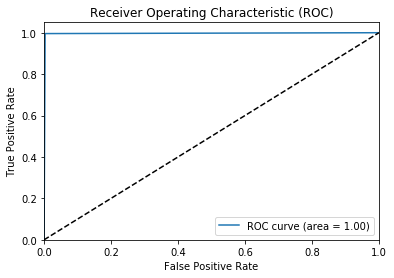

Fully connected neural network
Activation: sigmoid Number of layers:  3 Number of neurons: 100 Optimizer: adam
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 3s - loss: 2.1637 - val_loss: 0.7182
Epoch 2/1000
8217/8217 - 2s - loss: 0.7060 - val_loss: 0.7029
Epoch 3/1000
8217/8217 - 3s - loss: 0.6944 - val_loss: 0.6623
Epoch 4/1000
8217/8217 - 2s - loss: 0.4862 - val_loss: 0.2822
Epoch 5/1000
8217/8217 - 2s - loss: 0.1677 - val_loss: 0.1188
Epoch 6/1000
8217/8217 - 2s - loss: 0.0813 - val_loss: 0.0547
Epoch 7/1000
8217/8217 - 2s - loss: 0.0437 - val_loss: 0.0383
Epoch 8/1000
8217/8217 - 3s - loss: 0.0328 - val_loss: 0.0323
Epoch 9/1000
8217/8217 - 3s - loss: 0.0271 - val_loss: 0.0300
Epoch 10/1000
8217/8217 - 3s - loss: 0.0237 - val_loss: 0.0269
Epoch 11/1000
8217/8217 - 2s - loss: 0.0213 - val_loss: 0.0241
Epoch 12/1000
8217/8217 - 2s - loss: 0.0196 - val_loss: 0.0238
Epoch 13/1000
8217/8217 - 3s - loss: 0.0180 - val_loss: 0.0230
Epoch 14/1000
8217/8217 - 3s - 

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


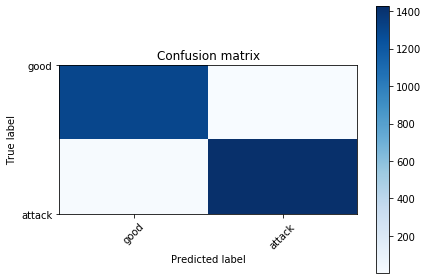

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1305
           1       1.00      0.99      1.00      1435

    accuracy                           1.00      2740
   macro avg       1.00      1.00      1.00      2740
weighted avg       1.00      1.00      1.00      2740



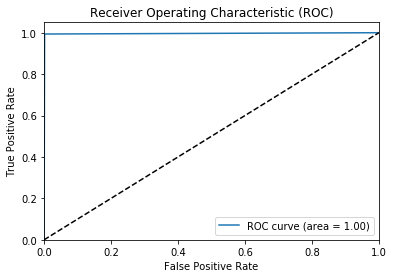

Fully connected neural network
Activation: tanh Number of layers:  3 Number of neurons: 100 Optimizer: adam
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 3s - loss: 2.1397 - val_loss: 0.1177
Epoch 2/1000
8217/8217 - 3s - loss: 0.0567 - val_loss: 0.0378
Epoch 3/1000
8217/8217 - 3s - loss: 0.0285 - val_loss: 0.0286
Epoch 4/1000
8217/8217 - 3s - loss: 0.0209 - val_loss: 0.0286
Epoch 5/1000
8217/8217 - 3s - loss: 0.0171 - val_loss: 0.0243
Epoch 6/1000
8217/8217 - 3s - loss: 0.0149 - val_loss: 0.0218
Epoch 7/1000
8217/8217 - 3s - loss: 0.0132 - val_loss: 0.0221
Epoch 8/1000
8217/8217 - 3s - loss: 0.0124 - val_loss: 0.0203
Epoch 9/1000
8217/8217 - 3s - loss: 0.0114 - val_loss: 0.0223
Epoch 10/1000
8217/8217 - 3s - loss: 0.0105 - val_loss: 0.0211
Epoch 00010: early stopping
[[9.9882537e-01 3.8361346e-04 8.6765581e-08 ... 9.5186699e-08
  9.4770584e-08 8.8298847e-08]
 [9.9416804e-01 4.0520737e-03 2.0248717e-07 ... 2.2179943e-07
  2.1397720e-07 1.9803475e-07]
 [6.35896

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


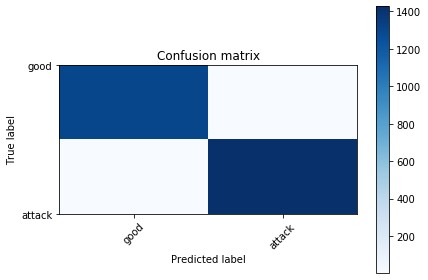

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1305
           1       1.00      0.99      1.00      1435

    accuracy                           1.00      2740
   macro avg       1.00      1.00      1.00      2740
weighted avg       1.00      1.00      1.00      2740



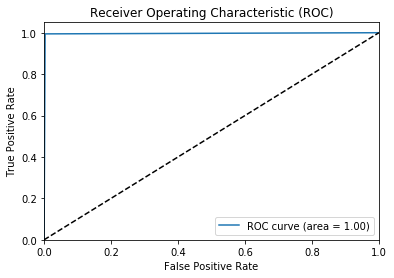

Fully connected neural network
Activation: relu Number of layers:  3 Number of neurons: 100 Optimizer: sgd
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 3s - loss: 2.4222 - val_loss: 0.1111
Epoch 2/1000
8217/8217 - 3s - loss: 0.0814 - val_loss: 0.0614
Epoch 3/1000
8217/8217 - 3s - loss: 0.0525 - val_loss: 0.0458
Epoch 4/1000
8217/8217 - 3s - loss: 0.0422 - val_loss: 0.0390
Epoch 5/1000
8217/8217 - 3s - loss: 0.0366 - val_loss: 0.0349
Epoch 6/1000
8217/8217 - 3s - loss: 0.0333 - val_loss: 0.0323
Epoch 7/1000
8217/8217 - 3s - loss: 0.0314 - val_loss: 0.0304
Epoch 8/1000
8217/8217 - 3s - loss: 0.0293 - val_loss: 0.0291
Epoch 9/1000
8217/8217 - 3s - loss: 0.0281 - val_loss: 0.0283
Epoch 10/1000
8217/8217 - 3s - loss: 0.0269 - val_loss: 0.0274
Epoch 11/1000
8217/8217 - 3s - loss: 0.0260 - val_loss: 0.0268
Epoch 12/1000
8217/8217 - 3s - loss: 0.0248 - val_loss: 0.0271
Epoch 00012: early stopping
[[9.9905652e-01 9.2775834e-04 2.3518743e-09 ... 2.3929971e-09
  2.7446

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


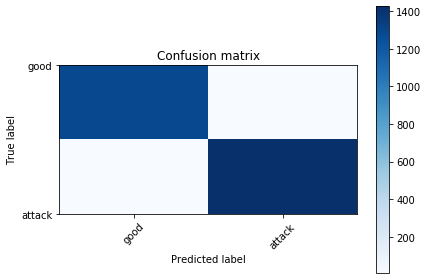

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1305
           1       0.99      0.99      0.99      1435

    accuracy                           0.99      2740
   macro avg       0.99      0.99      0.99      2740
weighted avg       0.99      0.99      0.99      2740



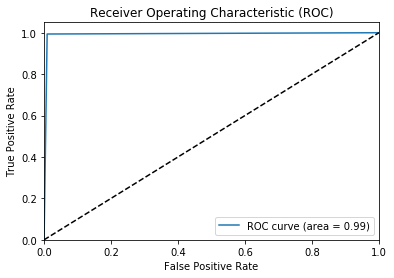

Fully connected neural network
Activation: sigmoid Number of layers:  3 Number of neurons: 100 Optimizer: sgd
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 3s - loss: 2.2993 - val_loss: 0.7127
Epoch 2/1000
8217/8217 - 3s - loss: 0.6826 - val_loss: 0.6605
Epoch 3/1000
8217/8217 - 3s - loss: 0.6299 - val_loss: 0.5940
Epoch 4/1000
8217/8217 - 3s - loss: 0.5419 - val_loss: 0.4783
Epoch 5/1000
8217/8217 - 3s - loss: 0.4019 - val_loss: 0.3251
Epoch 6/1000
8217/8217 - 3s - loss: 0.2683 - val_loss: 0.2204
Epoch 7/1000
8217/8217 - 3s - loss: 0.1909 - val_loss: 0.1692
Epoch 8/1000
8217/8217 - 3s - loss: 0.1526 - val_loss: 0.1428
Epoch 9/1000
8217/8217 - 3s - loss: 0.1312 - val_loss: 0.1270
Epoch 10/1000
8217/8217 - 3s - loss: 0.1173 - val_loss: 0.1162
Epoch 11/1000
8217/8217 - 3s - loss: 0.1070 - val_loss: 0.1085
Epoch 12/1000
8217/8217 - 3s - loss: 0.0991 - val_loss: 0.1003
Epoch 13/1000
8217/8217 - 3s - loss: 0.0923 - val_loss: 0.0941
Epoch 14/1000
8217/8217 - 3s - l

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


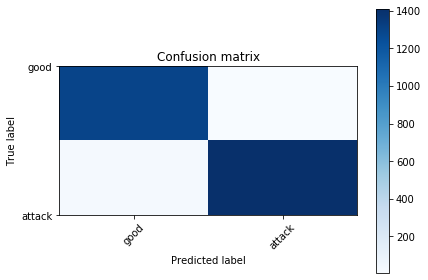

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1305
           1       1.00      0.98      0.99      1435

    accuracy                           0.99      2740
   macro avg       0.99      0.99      0.99      2740
weighted avg       0.99      0.99      0.99      2740



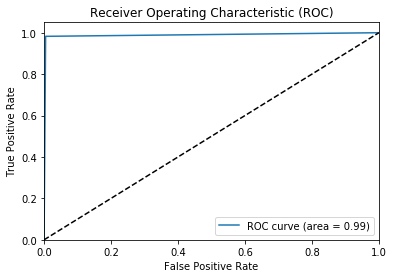

Fully connected neural network
Activation: tanh Number of layers:  3 Number of neurons: 100 Optimizer: sgd
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 3s - loss: 3.3486 - val_loss: 0.6034
Epoch 2/1000
8217/8217 - 3s - loss: 0.4444 - val_loss: 0.4137
Epoch 3/1000
8217/8217 - 2s - loss: 0.3119 - val_loss: 0.3462
Epoch 4/1000
8217/8217 - 2s - loss: 0.2115 - val_loss: 0.1579
Epoch 5/1000
8217/8217 - 2s - loss: 0.1027 - val_loss: 0.0820
Epoch 6/1000
8217/8217 - 2s - loss: 0.0651 - val_loss: 0.0603
Epoch 7/1000
8217/8217 - 2s - loss: 0.0502 - val_loss: 0.0497
Epoch 8/1000
8217/8217 - 2s - loss: 0.0417 - val_loss: 0.0437
Epoch 9/1000
8217/8217 - 2s - loss: 0.0363 - val_loss: 0.0397
Epoch 10/1000
8217/8217 - 3s - loss: 0.0326 - val_loss: 0.0368
Epoch 11/1000
8217/8217 - 3s - loss: 0.0297 - val_loss: 0.0356
Epoch 12/1000
8217/8217 - 3s - loss: 0.0281 - val_loss: 0.0334
Epoch 13/1000
8217/8217 - 2s - loss: 0.0264 - val_loss: 0.0326
Epoch 14/1000
8217/8217 - 3s - loss

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


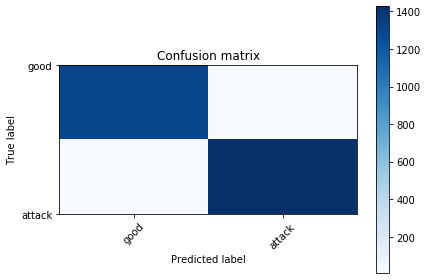

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1305
           1       0.99      0.99      0.99      1435

    accuracy                           0.99      2740
   macro avg       0.99      0.99      0.99      2740
weighted avg       0.99      0.99      0.99      2740



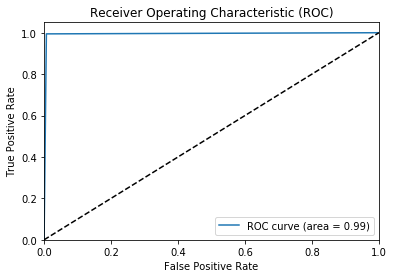

Fully connected neural network
Activation: relu Number of layers:  4 Number of neurons: 100 Optimizer: adam
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 3s - loss: 1.2874 - val_loss: 0.0257
Epoch 2/1000
8217/8217 - 2s - loss: 0.0226 - val_loss: 0.0198
Epoch 3/1000
8217/8217 - 2s - loss: 0.0229 - val_loss: 0.0226
Epoch 4/1000
8217/8217 - 2s - loss: 0.0175 - val_loss: 0.0189
Epoch 00004: early stopping
[[9.9969220e-01 3.0785869e-04 1.9074041e-12 ... 3.3395947e-12
  2.0665143e-12 1.8462178e-12]
 [9.8761058e-01 1.2389431e-02 4.3784264e-12 ... 8.5230616e-12
  6.2609063e-12 4.6005049e-12]
 [3.8891885e-05 9.9996114e-01 2.3777178e-16 ... 8.1242636e-16
  1.0159601e-15 2.5143612e-16]
 ...
 [9.9965203e-01 3.4796342e-04 1.7017335e-12 ... 2.9953520e-12
  1.8656728e-12 1.6382836e-12]
 [1.7782430e-04 9.9982220e-01 2.1909314e-14 ... 6.3147851e-14
  7.7251214e-14 2.2872771e-14]
 [1.2395227e-04 9.9987602e-01 7.4156422e-15 ... 2.2326066e-14
  2.7711408e-14 7.9213598e-15]]
[0 0

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


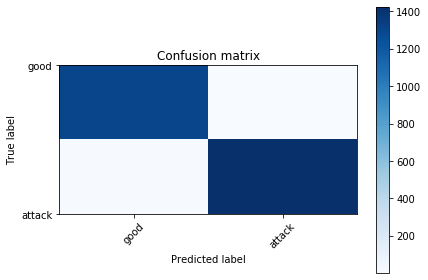

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1305
           1       1.00      0.99      1.00      1435

    accuracy                           1.00      2740
   macro avg       1.00      1.00      1.00      2740
weighted avg       1.00      1.00      1.00      2740



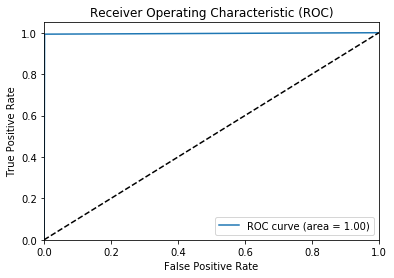

Fully connected neural network
Activation: sigmoid Number of layers:  4 Number of neurons: 100 Optimizer: adam
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 3s - loss: 2.7410 - val_loss: 0.7525
Epoch 2/1000
8217/8217 - 3s - loss: 0.7236 - val_loss: 0.7094
Epoch 3/1000
8217/8217 - 3s - loss: 0.7049 - val_loss: 0.7010
Epoch 4/1000
8217/8217 - 3s - loss: 0.6989 - val_loss: 0.6992
Epoch 5/1000
8217/8217 - 3s - loss: 0.6965 - val_loss: 0.6980
Epoch 6/1000
8217/8217 - 2s - loss: 0.6955 - val_loss: 0.6957
Epoch 7/1000
8217/8217 - 2s - loss: 0.6949 - val_loss: 0.6945
Epoch 8/1000
8217/8217 - 2s - loss: 0.6943 - val_loss: 0.6960
Epoch 9/1000
8217/8217 - 2s - loss: 0.6938 - val_loss: 0.6937
Epoch 00009: early stopping
[[4.6457312e-01 5.3397924e-01 1.6224381e-07 ... 1.8676734e-07
  1.7323288e-07 1.7020203e-07]
 [4.6458003e-01 5.3397191e-01 1.6228832e-07 ... 1.8681911e-07
  1.7327973e-07 1.7024774e-07]
 [4.6451715e-01 5.3403586e-01 1.6216866e-07 ... 1.8666942e-07
  1.731

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


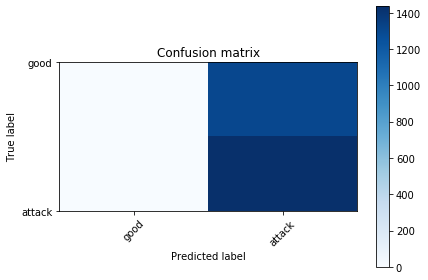

C:\Users\Psych\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1305
           1       0.52      1.00      0.69      1435

    accuracy                           0.52      2740
   macro avg       0.26      0.50      0.34      2740
weighted avg       0.27      0.52      0.36      2740



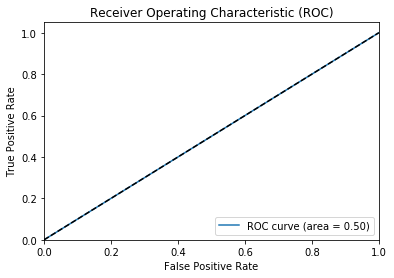

Fully connected neural network
Activation: tanh Number of layers:  4 Number of neurons: 100 Optimizer: adam
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 3s - loss: 3.4437 - val_loss: 0.3946
Epoch 2/1000
8217/8217 - 3s - loss: 0.1773 - val_loss: 0.0974
Epoch 3/1000
8217/8217 - 2s - loss: 0.0631 - val_loss: 0.0642
Epoch 4/1000
8217/8217 - 3s - loss: 0.0398 - val_loss: 0.0497
Epoch 5/1000
8217/8217 - 3s - loss: 0.0319 - val_loss: 0.0453
Epoch 6/1000
8217/8217 - 3s - loss: 0.0279 - val_loss: 0.0435
Epoch 7/1000
8217/8217 - 3s - loss: 0.0233 - val_loss: 0.0371
Epoch 8/1000
8217/8217 - 3s - loss: 0.0186 - val_loss: 0.0356
Epoch 9/1000
8217/8217 - 3s - loss: 0.0166 - val_loss: 0.0256
Epoch 10/1000
8217/8217 - 3s - loss: 0.0156 - val_loss: 0.0251
Epoch 11/1000
8217/8217 - 3s - loss: 0.0117 - val_loss: 0.0212
Epoch 12/1000
8217/8217 - 3s - loss: 0.0105 - val_loss: 0.0200
Epoch 13/1000
8217/8217 - 2s - loss: 0.0098 - val_loss: 0.0261
Epoch 14/1000
8217/8217 - 3s - los

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


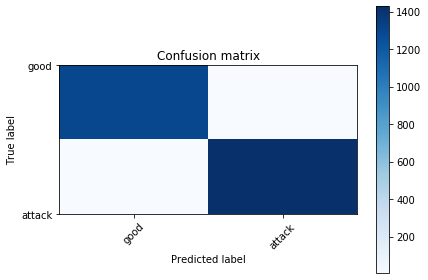

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1305
           1       1.00      1.00      1.00      1435

    accuracy                           0.99      2740
   macro avg       0.99      0.99      0.99      2740
weighted avg       0.99      0.99      0.99      2740



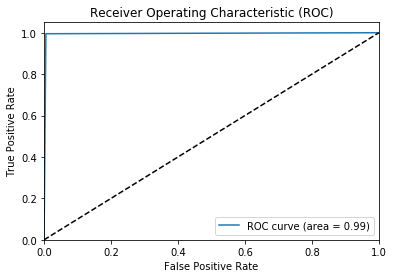

Fully connected neural network
Activation: relu Number of layers:  4 Number of neurons: 100 Optimizer: sgd
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 3s - loss: 2.5073 - val_loss: 0.1019
Epoch 2/1000
8217/8217 - 2s - loss: 0.0723 - val_loss: 0.0566
Epoch 3/1000
8217/8217 - 2s - loss: 0.0458 - val_loss: 0.0458
Epoch 4/1000
8217/8217 - 2s - loss: 0.0351 - val_loss: 0.0317
Epoch 5/1000
8217/8217 - 2s - loss: 0.0301 - val_loss: 0.0284
Epoch 6/1000
8217/8217 - 2s - loss: 0.0270 - val_loss: 0.0272
Epoch 7/1000
8217/8217 - 2s - loss: 0.0253 - val_loss: 0.0252
Epoch 8/1000
8217/8217 - 2s - loss: 0.0244 - val_loss: 0.0245
Epoch 9/1000
8217/8217 - 2s - loss: 0.0230 - val_loss: 0.0245
Epoch 00009: early stopping
[[9.99628425e-01 3.67466651e-04 4.32820835e-10 ... 8.92417251e-10
  6.28292862e-10 5.16725995e-10]
 [8.80016088e-01 1.19965844e-01 2.14087481e-09 ... 5.03458208e-09
  3.30450645e-09 2.82320722e-09]
 [2.23911866e-05 9.99976277e-01 1.21932256e-10 ... 3.03700565

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


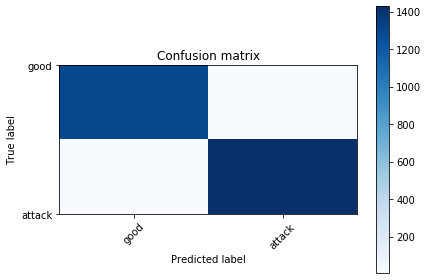

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1305
           1       0.99      1.00      0.99      1435

    accuracy                           0.99      2740
   macro avg       0.99      0.99      0.99      2740
weighted avg       0.99      0.99      0.99      2740



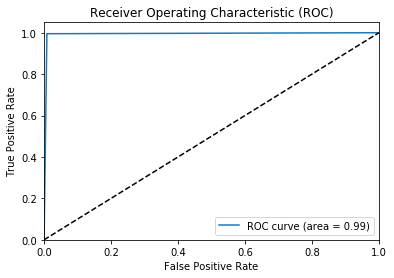

Fully connected neural network
Activation: sigmoid Number of layers:  4 Number of neurons: 100 Optimizer: sgd
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 3s - loss: 3.1398 - val_loss: 0.7567
Epoch 2/1000
8217/8217 - 2s - loss: 0.7254 - val_loss: 0.7111
Epoch 3/1000
8217/8217 - 4s - loss: 0.7053 - val_loss: 0.7024
Epoch 4/1000
8217/8217 - 2s - loss: 0.7004 - val_loss: 0.6992
Epoch 5/1000
8217/8217 - 2s - loss: 0.6970 - val_loss: 0.6964
Epoch 6/1000
8217/8217 - 2s - loss: 0.6948 - val_loss: 0.6945
Epoch 7/1000
8217/8217 - 2s - loss: 0.6937 - val_loss: 0.6937
Epoch 8/1000
8217/8217 - 2s - loss: 0.6918 - val_loss: 0.6914
Epoch 9/1000
8217/8217 - 2s - loss: 0.6909 - val_loss: 0.6909
Epoch 10/1000
8217/8217 - 2s - loss: 0.6888 - val_loss: 0.6877
Epoch 11/1000
8217/8217 - 2s - loss: 0.6862 - val_loss: 0.6848
Epoch 12/1000
8217/8217 - 2s - loss: 0.6828 - val_loss: 0.6832
Epoch 13/1000
8217/8217 - 2s - loss: 0.6795 - val_loss: 0.6782
Epoch 14/1000
8217/8217 - 2s - l

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


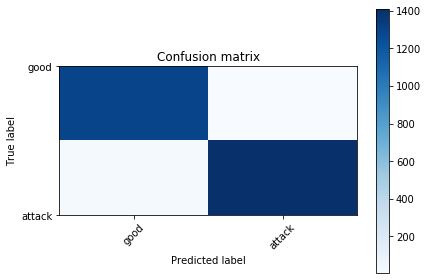

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1305
           1       1.00      0.98      0.99      1435

    accuracy                           0.99      2740
   macro avg       0.99      0.99      0.99      2740
weighted avg       0.99      0.99      0.99      2740



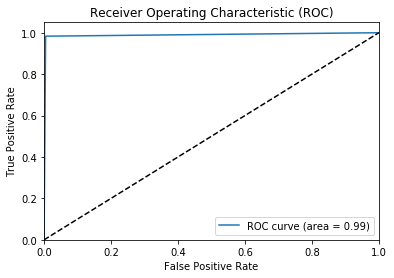

Fully connected neural network
Activation: tanh Number of layers:  4 Number of neurons: 100 Optimizer: sgd
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 3s - loss: 3.3151 - val_loss: 0.4263
Epoch 2/1000
8217/8217 - 2s - loss: 0.3066 - val_loss: 0.2637
Epoch 3/1000
8217/8217 - 2s - loss: 0.2320 - val_loss: 0.2092
Epoch 4/1000
8217/8217 - 2s - loss: 0.1677 - val_loss: 0.1264
Epoch 5/1000
8217/8217 - 3s - loss: 0.1165 - val_loss: 0.0947
Epoch 6/1000
8217/8217 - 2s - loss: 0.0915 - val_loss: 0.0787
Epoch 7/1000
8217/8217 - 2s - loss: 0.0773 - val_loss: 0.0709
Epoch 8/1000
8217/8217 - 2s - loss: 0.0679 - val_loss: 0.0658
Epoch 9/1000
8217/8217 - 2s - loss: 0.0620 - val_loss: 0.0560
Epoch 10/1000
8217/8217 - 2s - loss: 0.0558 - val_loss: 0.0534
Epoch 11/1000
8217/8217 - 2s - loss: 0.0518 - val_loss: 0.0506
Epoch 12/1000
8217/8217 - 2s - loss: 0.0477 - val_loss: 0.0474
Epoch 13/1000
8217/8217 - 2s - loss: 0.0441 - val_loss: 0.0454
Epoch 14/1000
8217/8217 - 2s - loss

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


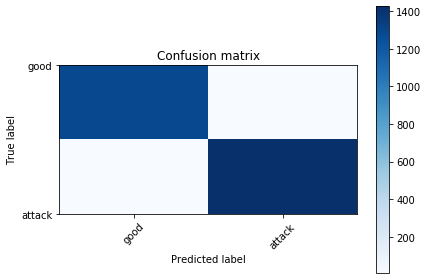

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1305
           1       0.99      0.99      0.99      1435

    accuracy                           0.99      2740
   macro avg       0.99      0.99      0.99      2740
weighted avg       0.99      0.99      0.99      2740



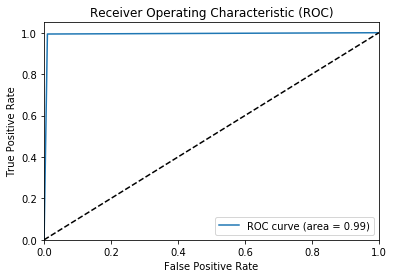

Fully connected neural network
Activation: relu Number of layers:  5 Number of neurons: 100 Optimizer: adam
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 3s - loss: 1.1408 - val_loss: 0.0287
Epoch 2/1000
8217/8217 - 3s - loss: 0.0259 - val_loss: 0.0254
Epoch 3/1000
8217/8217 - 2s - loss: 0.0202 - val_loss: 0.0209
Epoch 4/1000
8217/8217 - 2s - loss: 0.0209 - val_loss: 0.0252
Epoch 5/1000
8217/8217 - 3s - loss: 0.0172 - val_loss: 0.0226
Epoch 00005: early stopping
[[9.9893528e-01 1.0647648e-03 1.0490054e-12 ... 1.1900009e-13
  4.9242289e-13 4.6979526e-13]
 [9.7894925e-01 2.1050755e-02 5.6942201e-11 ... 7.4851497e-12
  2.3498335e-11 2.7792253e-11]
 [2.9729586e-07 9.9999976e-01 9.9117645e-18 ... 1.0086490e-18
  4.6254802e-18 1.8311234e-17]
 ...
 [9.9899632e-01 1.0036386e-03 6.0574023e-13 ... 6.4680595e-14
  2.7487246e-13 2.6391758e-13]
 [4.6381028e-06 9.9999535e-01 1.1241412e-14 ... 1.7185358e-15
  5.9743690e-15 1.8386846e-14]
 [9.7557620e-07 9.9999905e-01 2.3163

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


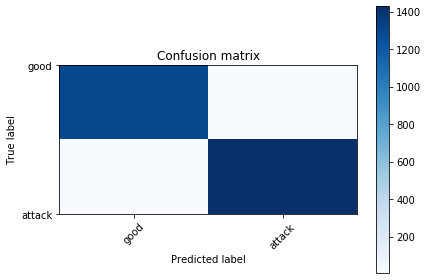

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1305
           1       0.99      1.00      0.99      1435

    accuracy                           0.99      2740
   macro avg       0.99      0.99      0.99      2740
weighted avg       0.99      0.99      0.99      2740



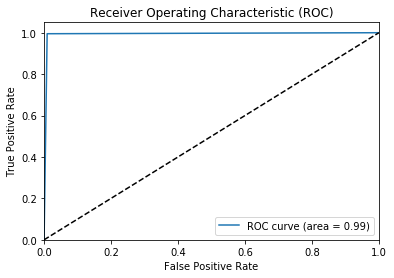

Fully connected neural network
Activation: sigmoid Number of layers:  5 Number of neurons: 100 Optimizer: adam
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 3s - loss: 3.4004 - val_loss: 0.8131
Epoch 2/1000
8217/8217 - 2s - loss: 0.7490 - val_loss: 0.7214
Epoch 3/1000
8217/8217 - 2s - loss: 0.7114 - val_loss: 0.7067
Epoch 4/1000
8217/8217 - 2s - loss: 0.7034 - val_loss: 0.7008
Epoch 5/1000
8217/8217 - 2s - loss: 0.6988 - val_loss: 0.6998
Epoch 6/1000
8217/8217 - 2s - loss: 0.6973 - val_loss: 0.6966
Epoch 7/1000
8217/8217 - 2s - loss: 0.6959 - val_loss: 0.6956
Epoch 8/1000
8217/8217 - 2s - loss: 0.6951 - val_loss: 0.6952
Epoch 9/1000
8217/8217 - 2s - loss: 0.6948 - val_loss: 0.6944
Epoch 10/1000
8217/8217 - 2s - loss: 0.6943 - val_loss: 0.6938
Epoch 11/1000
8217/8217 - 2s - loss: 0.6937 - val_loss: 0.6947
Epoch 12/1000
8217/8217 - 3s - loss: 0.6937 - val_loss: 0.6935
Epoch 00012: early stopping
[[4.6473557e-01 5.3397828e-01 1.6571795e-07 ... 1.6199800e-07
  1.

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


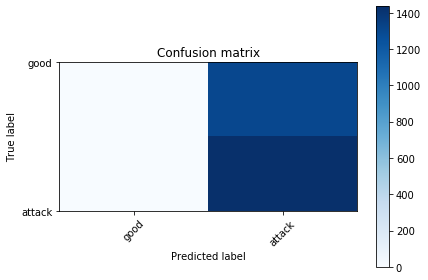

C:\Users\Psych\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1305
           1       0.52      1.00      0.69      1435

    accuracy                           0.52      2740
   macro avg       0.26      0.50      0.34      2740
weighted avg       0.27      0.52      0.36      2740



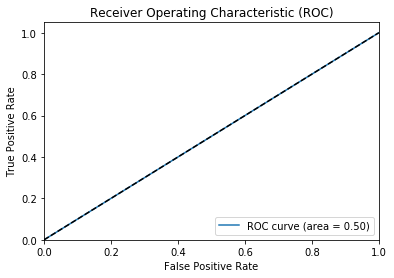

Fully connected neural network
Activation: tanh Number of layers:  5 Number of neurons: 100 Optimizer: adam
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 3s - loss: 3.8217 - val_loss: 0.3711
Epoch 2/1000
8217/8217 - 2s - loss: 0.1681 - val_loss: 0.0967
Epoch 3/1000
8217/8217 - 2s - loss: 0.0648 - val_loss: 0.0562
Epoch 4/1000
8217/8217 - 2s - loss: 0.0414 - val_loss: 0.0370
Epoch 5/1000
8217/8217 - 2s - loss: 0.0304 - val_loss: 0.0326
Epoch 6/1000
8217/8217 - 2s - loss: 0.0246 - val_loss: 0.0296
Epoch 7/1000
8217/8217 - 2s - loss: 0.0206 - val_loss: 0.0274
Epoch 8/1000
8217/8217 - 2s - loss: 0.0182 - val_loss: 0.0261
Epoch 9/1000
8217/8217 - 2s - loss: 0.0174 - val_loss: 0.0268
Epoch 10/1000
8217/8217 - 2s - loss: 0.0169 - val_loss: 0.0730
Epoch 00010: early stopping
[[9.9710053e-01 3.5641080e-04 2.7723749e-07 ... 3.0056043e-07
  3.1747507e-07 3.0993507e-07]
 [9.9708611e-01 3.5921772e-04 2.7833764e-07 ... 3.0172265e-07
  3.1876317e-07 3.1115314e-07]
 [3.38249

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


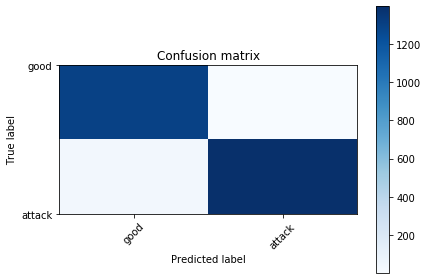

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1305
           1       1.00      0.97      0.99      1435

    accuracy                           0.99      2740
   macro avg       0.99      0.99      0.99      2740
weighted avg       0.99      0.99      0.99      2740



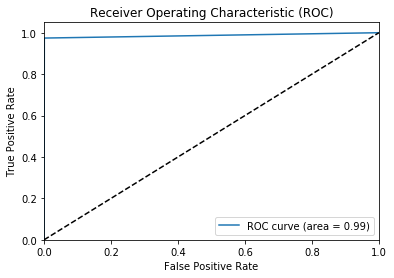

Fully connected neural network
Activation: relu Number of layers:  5 Number of neurons: 100 Optimizer: sgd
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 3s - loss: 2.6897 - val_loss: 0.0842
Epoch 2/1000
8217/8217 - 2s - loss: 0.0598 - val_loss: 0.0409
Epoch 3/1000
8217/8217 - 2s - loss: 0.0356 - val_loss: 0.0304
Epoch 4/1000
8217/8217 - 2s - loss: 0.0299 - val_loss: 0.0280
Epoch 5/1000
8217/8217 - 2s - loss: 0.0265 - val_loss: 0.0262
Epoch 6/1000
8217/8217 - 3s - loss: 0.0250 - val_loss: 0.0259
Epoch 7/1000
8217/8217 - 2s - loss: 0.0235 - val_loss: 0.0242
Epoch 8/1000
8217/8217 - 2s - loss: 0.0245 - val_loss: 0.0240
Epoch 9/1000
8217/8217 - 2s - loss: 0.0234 - val_loss: 0.0243
Epoch 00009: early stopping
[[9.9977726e-01 2.1929633e-04 2.8413358e-10 ... 5.5791005e-10
  3.8390149e-10 4.6274257e-10]
 [9.6473408e-01 3.5264783e-02 9.2984717e-11 ... 2.0054133e-10
  1.1304801e-10 1.7101824e-10]
 [4.0211329e-05 9.9995899e-01 7.0915732e-11 ... 1.1774766e-10
  6.0885678

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


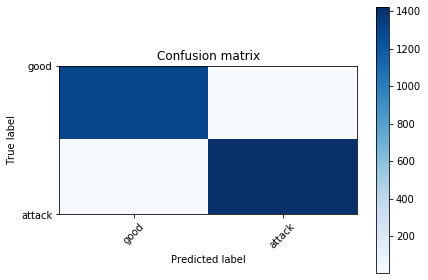

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1305
           1       1.00      0.99      0.99      1435

    accuracy                           0.99      2740
   macro avg       0.99      0.99      0.99      2740
weighted avg       0.99      0.99      0.99      2740



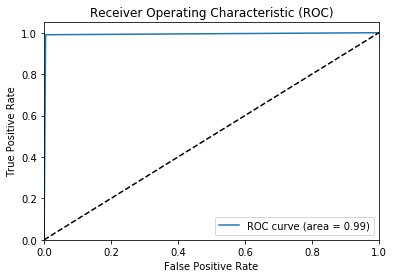

Fully connected neural network
Activation: sigmoid Number of layers:  5 Number of neurons: 100 Optimizer: sgd
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 3s - loss: 3.7174 - val_loss: 0.7984
Epoch 2/1000
8217/8217 - 2s - loss: 0.7423 - val_loss: 0.7238
Epoch 3/1000
8217/8217 - 2s - loss: 0.7121 - val_loss: 0.7072
Epoch 4/1000
8217/8217 - 3s - loss: 0.7045 - val_loss: 0.7032
Epoch 5/1000
8217/8217 - 2s - loss: 0.7009 - val_loss: 0.6999
Epoch 6/1000
8217/8217 - 2s - loss: 0.6992 - val_loss: 0.6984
Epoch 7/1000
8217/8217 - 2s - loss: 0.6977 - val_loss: 0.6986
Epoch 8/1000
8217/8217 - 2s - loss: 0.6967 - val_loss: 0.6990
Epoch 00008: early stopping
[[4.3911707e-01 5.5631971e-01 5.8475416e-07 ... 5.2262192e-07
  5.3030959e-07 4.7686524e-07]
 [4.3914822e-01 5.5625361e-01 5.8917317e-07 ... 5.2667338e-07
  5.3435951e-07 4.8056427e-07]
 [4.3902001e-01 5.5642009e-01 5.8436126e-07 ... 5.2217263e-07
  5.2981375e-07 4.7642027e-07]
 ...
 [4.3911335e-01 5.5631924e-01 5.85

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


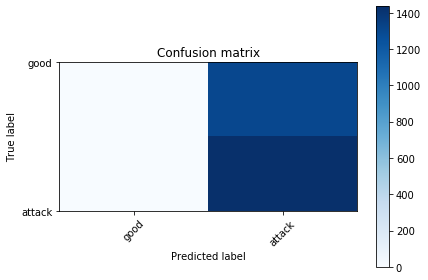

C:\Users\Psych\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1305
           1       0.52      1.00      0.69      1435

    accuracy                           0.52      2740
   macro avg       0.26      0.50      0.34      2740
weighted avg       0.27      0.52      0.36      2740



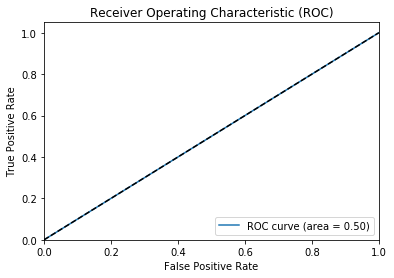

Fully connected neural network
Activation: tanh Number of layers:  5 Number of neurons: 100 Optimizer: sgd
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 2s - loss: 3.7010 - val_loss: 0.3922
Epoch 2/1000
8217/8217 - 2s - loss: 0.2120 - val_loss: 0.1327
Epoch 3/1000
8217/8217 - 2s - loss: 0.0986 - val_loss: 0.0859
Epoch 4/1000
8217/8217 - 2s - loss: 0.0712 - val_loss: 0.0659
Epoch 5/1000
8217/8217 - 2s - loss: 0.0546 - val_loss: 0.0562
Epoch 6/1000
8217/8217 - 2s - loss: 0.0469 - val_loss: 0.0493
Epoch 7/1000
8217/8217 - 2s - loss: 0.0397 - val_loss: 0.0464
Epoch 8/1000
8217/8217 - 2s - loss: 0.0360 - val_loss: 0.0407
Epoch 9/1000
8217/8217 - 2s - loss: 0.0317 - val_loss: 0.0405
Epoch 10/1000
8217/8217 - 2s - loss: 0.0281 - val_loss: 0.0382
Epoch 11/1000
8217/8217 - 2s - loss: 0.0259 - val_loss: 0.0361
Epoch 12/1000
8217/8217 - 2s - loss: 0.0241 - val_loss: 0.0345
Epoch 13/1000
8217/8217 - 2s - loss: 0.0229 - val_loss: 0.0328
Epoch 14/1000
8217/8217 - 2s - loss

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


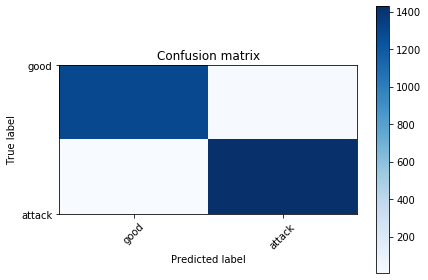

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1305
           1       0.99      1.00      0.99      1435

    accuracy                           0.99      2740
   macro avg       0.99      0.99      0.99      2740
weighted avg       0.99      0.99      0.99      2740



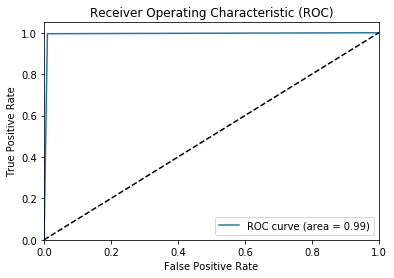

Fully connected neural network
Activation: relu Number of layers:  4 Number of neurons: 50 Optimizer: adam
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 2s - loss: 1.7657 - val_loss: 0.0368
Epoch 2/1000
8217/8217 - 2s - loss: 0.0274 - val_loss: 0.0241
Epoch 3/1000
8217/8217 - 2s - loss: 0.0205 - val_loss: 0.0220
Epoch 4/1000
8217/8217 - 2s - loss: 0.0175 - val_loss: 0.0206
Epoch 5/1000
8217/8217 - 2s - loss: 0.0156 - val_loss: 0.0219
Epoch 6/1000
8217/8217 - 2s - loss: 0.0143 - val_loss: 0.0182
Epoch 7/1000
8217/8217 - 2s - loss: 0.0137 - val_loss: 0.0184
Epoch 8/1000
8217/8217 - 2s - loss: 0.0136 - val_loss: 0.0172
Epoch 9/1000
8217/8217 - 2s - loss: 0.0121 - val_loss: 0.0172
Epoch 10/1000
8217/8217 - 2s - loss: 0.0103 - val_loss: 0.0167
Epoch 00010: early stopping
[[9.9943715e-01 5.6106522e-04 2.7905578e-10 ... 3.0684549e-10
  1.1799256e-10 2.5795449e-10]
 [9.8506814e-01 1.4917297e-02 2.1260882e-09 ... 2.3234601e-09
  1.0389472e-09 1.9212665e-09]
 [1.312522

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


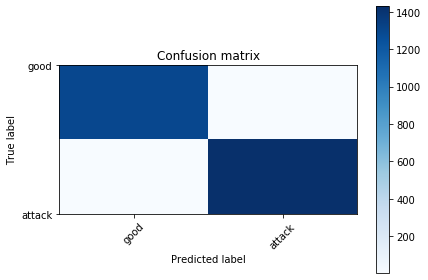

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1305
           1       1.00      1.00      1.00      1435

    accuracy                           1.00      2740
   macro avg       1.00      1.00      1.00      2740
weighted avg       1.00      1.00      1.00      2740



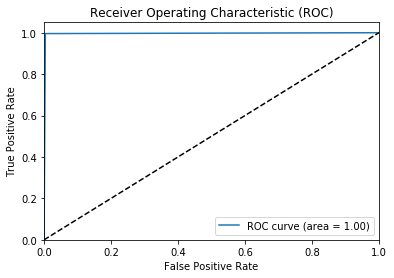

Fully connected neural network
Activation: sigmoid Number of layers:  4 Number of neurons: 50 Optimizer: adam
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 2s - loss: 4.6082 - val_loss: 1.1569
Epoch 2/1000
8217/8217 - 2s - loss: 0.8609 - val_loss: 0.7598
Epoch 3/1000
8217/8217 - 2s - loss: 0.7362 - val_loss: 0.7224
Epoch 4/1000
8217/8217 - 2s - loss: 0.7146 - val_loss: 0.7101
Epoch 5/1000
8217/8217 - 2s - loss: 0.7062 - val_loss: 0.7040
Epoch 6/1000
8217/8217 - 2s - loss: 0.7014 - val_loss: 0.7007
Epoch 7/1000
8217/8217 - 2s - loss: 0.6991 - val_loss: 0.6988
Epoch 8/1000
8217/8217 - 2s - loss: 0.6973 - val_loss: 0.6975
Epoch 9/1000
8217/8217 - 2s - loss: 0.6963 - val_loss: 0.6969
Epoch 10/1000
8217/8217 - 2s - loss: 0.6952 - val_loss: 0.6968
Epoch 00010: early stopping
[[4.4827831e-01 5.4833722e-01 4.4276669e-07 ... 3.7912903e-07
  3.9855414e-07 4.4249398e-07]
 [4.4827855e-01 5.4833674e-01 4.4281447e-07 ... 3.7917061e-07
  3.9859674e-07 4.4254134e-07]
 [4.482

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


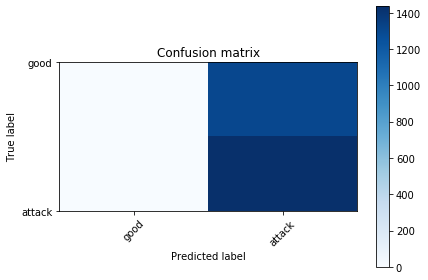

C:\Users\Psych\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1305
           1       0.52      1.00      0.69      1435

    accuracy                           0.52      2740
   macro avg       0.26      0.50      0.34      2740
weighted avg       0.27      0.52      0.36      2740



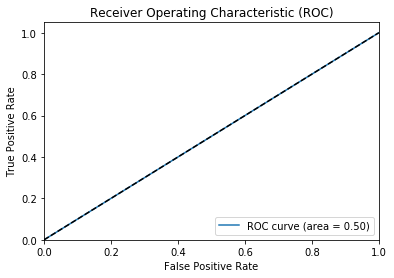

Fully connected neural network
Activation: tanh Number of layers:  4 Number of neurons: 50 Optimizer: adam
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 3s - loss: 5.4155 - val_loss: 1.8992
Epoch 2/1000
8217/8217 - 2s - loss: 0.6633 - val_loss: 0.2271
Epoch 3/1000
8217/8217 - 2s - loss: 0.1346 - val_loss: 0.0889
Epoch 4/1000
8217/8217 - 2s - loss: 0.0705 - val_loss: 0.0623
Epoch 5/1000
8217/8217 - 2s - loss: 0.0467 - val_loss: 0.0471
Epoch 6/1000
8217/8217 - 2s - loss: 0.0341 - val_loss: 0.0407
Epoch 7/1000
8217/8217 - 2s - loss: 0.0272 - val_loss: 0.0346
Epoch 8/1000
8217/8217 - 2s - loss: 0.0242 - val_loss: 0.0421
Epoch 9/1000
8217/8217 - 2s - loss: 0.0206 - val_loss: 0.0327
Epoch 10/1000
8217/8217 - 2s - loss: 0.0180 - val_loss: 0.0289
Epoch 11/1000
8217/8217 - 2s - loss: 0.0154 - val_loss: 0.0293
Epoch 12/1000
8217/8217 - 2s - loss: 0.0138 - val_loss: 0.0264
Epoch 13/1000
8217/8217 - 2s - loss: 0.0133 - val_loss: 0.0293
Epoch 14/1000
8217/8217 - 2s - loss

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


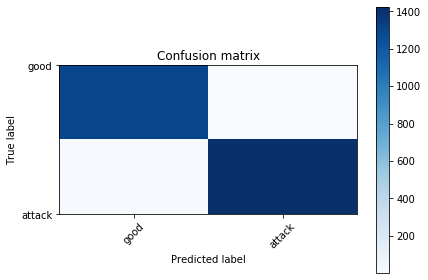

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1305
           1       1.00      0.99      0.99      1435

    accuracy                           0.99      2740
   macro avg       0.99      0.99      0.99      2740
weighted avg       0.99      0.99      0.99      2740



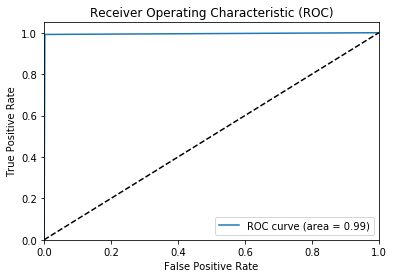

Fully connected neural network
Activation: relu Number of layers:  4 Number of neurons: 50 Optimizer: sgd
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 2s - loss: 2.7756 - val_loss: 0.1035
Epoch 2/1000
8217/8217 - 2s - loss: 0.0759 - val_loss: 0.0537
Epoch 3/1000
8217/8217 - 2s - loss: 0.0490 - val_loss: 0.0406
Epoch 4/1000
8217/8217 - 2s - loss: 0.0393 - val_loss: 0.0331
Epoch 5/1000
8217/8217 - 2s - loss: 0.0339 - val_loss: 0.0300
Epoch 6/1000
8217/8217 - 2s - loss: 0.0305 - val_loss: 0.0278
Epoch 7/1000
8217/8217 - 2s - loss: 0.0280 - val_loss: 0.0261
Epoch 8/1000
8217/8217 - 2s - loss: 0.0263 - val_loss: 0.0248
Epoch 9/1000
8217/8217 - 2s - loss: 0.0247 - val_loss: 0.0240
Epoch 10/1000
8217/8217 - 2s - loss: 0.0248 - val_loss: 0.0234
Epoch 11/1000
8217/8217 - 2s - loss: 0.0227 - val_loss: 0.0231
Epoch 12/1000
8217/8217 - 2s - loss: 0.0226 - val_loss: 0.0243
Epoch 00012: early stopping
[[9.9992216e-01 7.7006975e-05 1.4367448e-10 ... 1.3152011e-10
  1.12062

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


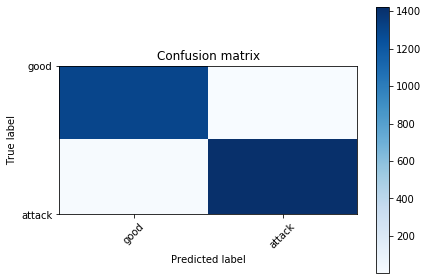

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1305
           1       1.00      0.99      0.99      1435

    accuracy                           0.99      2740
   macro avg       0.99      0.99      0.99      2740
weighted avg       0.99      0.99      0.99      2740



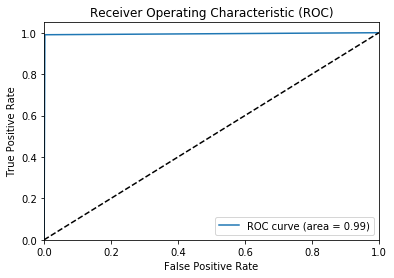

Fully connected neural network
Activation: sigmoid Number of layers:  4 Number of neurons: 50 Optimizer: sgd
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 2s - loss: 4.7651 - val_loss: 1.0190
Epoch 2/1000
8217/8217 - 2s - loss: 0.8083 - val_loss: 0.7419
Epoch 3/1000
8217/8217 - 2s - loss: 0.7267 - val_loss: 0.7174
Epoch 4/1000
8217/8217 - 2s - loss: 0.7115 - val_loss: 0.7124
Epoch 5/1000
8217/8217 - 2s - loss: 0.7058 - val_loss: 0.7047
Epoch 6/1000
8217/8217 - 2s - loss: 0.7022 - val_loss: 0.7019
Epoch 7/1000
8217/8217 - 2s - loss: 0.7002 - val_loss: 0.7002
Epoch 8/1000
8217/8217 - 2s - loss: 0.6983 - val_loss: 0.6990
Epoch 9/1000
8217/8217 - 2s - loss: 0.6973 - val_loss: 0.6969
Epoch 10/1000
8217/8217 - 2s - loss: 0.6961 - val_loss: 0.6961
Epoch 11/1000
8217/8217 - 2s - loss: 0.6950 - val_loss: 0.6958
Epoch 12/1000
8217/8217 - 2s - loss: 0.6943 - val_loss: 0.6985
Epoch 13/1000
8217/8217 - 2s - loss: 0.6935 - val_loss: 0.6937
Epoch 14/1000
8217/8217 - 2s - lo

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


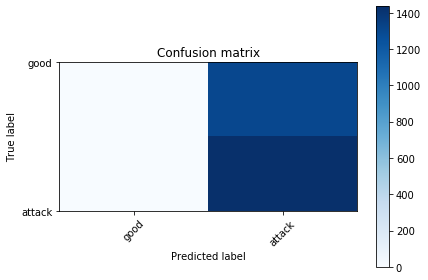

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1305
           1       0.52      1.00      0.69      1435

    accuracy                           0.52      2740
   macro avg       0.26      0.50      0.34      2740
weighted avg       0.27      0.52      0.36      2740



C:\Users\Psych\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


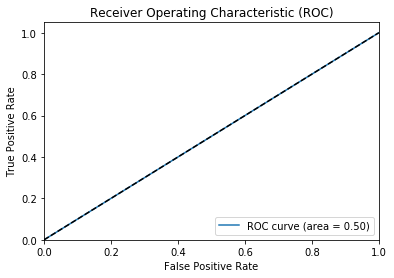

Fully connected neural network
Activation: tanh Number of layers:  4 Number of neurons: 50 Optimizer: sgd
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 2s - loss: 4.3586 - val_loss: 0.6596
Epoch 2/1000
8217/8217 - 2s - loss: 0.4194 - val_loss: 0.4164
Epoch 3/1000
8217/8217 - 2s - loss: 0.3198 - val_loss: 0.3718
Epoch 4/1000
8217/8217 - 2s - loss: 0.2886 - val_loss: 0.3416
Epoch 5/1000
8217/8217 - 2s - loss: 0.2612 - val_loss: 0.2309
Epoch 6/1000
8217/8217 - 2s - loss: 0.2051 - val_loss: 0.1817
Epoch 7/1000
8217/8217 - 2s - loss: 0.1440 - val_loss: 0.1345
Epoch 8/1000
8217/8217 - 2s - loss: 0.1147 - val_loss: 0.1130
Epoch 9/1000
8217/8217 - 2s - loss: 0.1040 - val_loss: 0.1132
Epoch 10/1000
8217/8217 - 2s - loss: 0.0947 - val_loss: 0.0954
Epoch 11/1000
8217/8217 - 2s - loss: 0.0880 - val_loss: 0.1008
Epoch 12/1000
8217/8217 - 2s - loss: 0.0842 - val_loss: 0.0913
Epoch 13/1000
8217/8217 - 2s - loss: 0.0781 - val_loss: 0.1020
Epoch 14/1000
8217/8217 - 2s - loss:

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


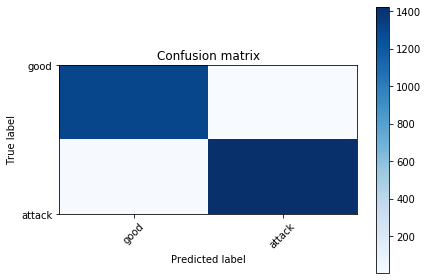

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1305
           1       1.00      0.99      0.99      1435

    accuracy                           0.99      2740
   macro avg       0.99      0.99      0.99      2740
weighted avg       0.99      0.99      0.99      2740



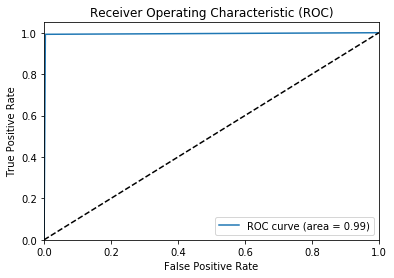

Fully connected neural network
Activation: relu Number of layers:  5 Number of neurons: 50 Optimizer: adam
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 3s - loss: 1.7772 - val_loss: 0.0403
Epoch 2/1000
8217/8217 - 3s - loss: 0.0269 - val_loss: 0.0284
Epoch 3/1000
8217/8217 - 2s - loss: 0.0213 - val_loss: 0.0191
Epoch 4/1000
8217/8217 - 3s - loss: 0.0149 - val_loss: 0.0175
Epoch 5/1000
8217/8217 - 2s - loss: 0.0155 - val_loss: 0.0174
Epoch 6/1000
8217/8217 - 2s - loss: 0.0124 - val_loss: 0.0182
Epoch 00006: early stopping
[[9.9978739e-01 2.1263598e-04 4.3021532e-14 ... 3.9476214e-14
  3.4301192e-14 5.5254439e-14]
 [9.6520996e-01 3.4789912e-02 1.7012785e-11 ... 1.5803673e-11
  1.2386264e-11 2.1942651e-11]
 [6.4849593e-07 9.9999940e-01 2.4832298e-16 ... 2.1670521e-16
  6.2682496e-17 3.4679498e-16]
 ...
 [9.9979013e-01 2.0987866e-04 3.9530272e-14 ... 3.6246935e-14
  3.1604710e-14 5.0795156e-14]
 [4.2011943e-06 9.9999583e-01 1.3925185e-14 ... 1.2357494e-14
  4.19

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


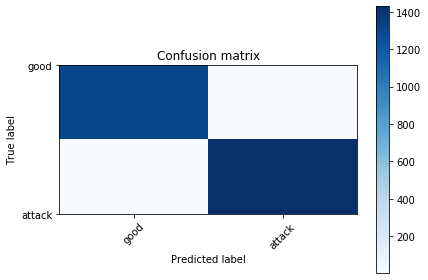

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1305
           1       1.00      1.00      1.00      1435

    accuracy                           1.00      2740
   macro avg       1.00      1.00      1.00      2740
weighted avg       1.00      1.00      1.00      2740



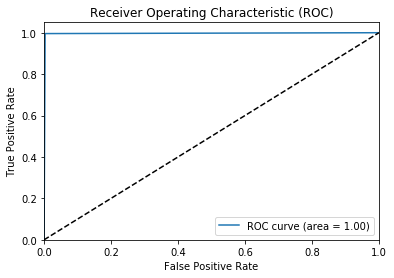

Fully connected neural network
Activation: sigmoid Number of layers:  5 Number of neurons: 50 Optimizer: adam
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 3s - loss: 5.5099 - val_loss: 2.0373
Epoch 2/1000
8217/8217 - 2s - loss: 1.1312 - val_loss: 0.8270
Epoch 3/1000
8217/8217 - 2s - loss: 0.7750 - val_loss: 0.7451
Epoch 4/1000
8217/8217 - 2s - loss: 0.7310 - val_loss: 0.7218
Epoch 5/1000
8217/8217 - 2s - loss: 0.7152 - val_loss: 0.7117
Epoch 6/1000
8217/8217 - 2s - loss: 0.7079 - val_loss: 0.7065
Epoch 7/1000
8217/8217 - 2s - loss: 0.7033 - val_loss: 0.7025
Epoch 8/1000
8217/8217 - 2s - loss: 0.7008 - val_loss: 0.7011
Epoch 9/1000
8217/8217 - 2s - loss: 0.6989 - val_loss: 0.6989
Epoch 10/1000
8217/8217 - 2s - loss: 0.6973 - val_loss: 0.6983
Epoch 11/1000
8217/8217 - 2s - loss: 0.6963 - val_loss: 0.6975
Epoch 12/1000
8217/8217 - 2s - loss: 0.6955 - val_loss: 0.6964
Epoch 13/1000
8217/8217 - 2s - loss: 0.6951 - val_loss: 0.6952
Epoch 14/1000
8217/8217 - 2s - l

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


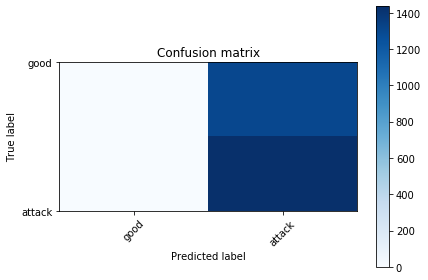

C:\Users\Psych\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1305
           1       0.52      1.00      0.69      1435

    accuracy                           0.52      2740
   macro avg       0.26      0.50      0.34      2740
weighted avg       0.27      0.52      0.36      2740



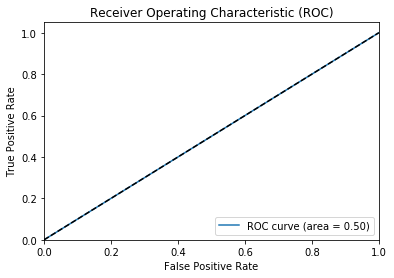

Fully connected neural network
Activation: tanh Number of layers:  5 Number of neurons: 50 Optimizer: adam
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 3s - loss: 5.4296 - val_loss: 2.1905
Epoch 2/1000
8217/8217 - 2s - loss: 1.1954 - val_loss: 0.8430
Epoch 3/1000
8217/8217 - 2s - loss: 0.7840 - val_loss: 0.7504
Epoch 4/1000
8217/8217 - 2s - loss: 0.7347 - val_loss: 0.7244
Epoch 5/1000
8217/8217 - 2s - loss: 0.7174 - val_loss: 0.7137
Epoch 6/1000
8217/8217 - 2s - loss: 0.7089 - val_loss: 0.7079
Epoch 7/1000
8217/8217 - 2s - loss: 0.7046 - val_loss: 0.7032
Epoch 8/1000
8217/8217 - 2s - loss: 0.7012 - val_loss: 0.7007
Epoch 9/1000
8217/8217 - 2s - loss: 0.6994 - val_loss: 0.6990
Epoch 10/1000
8217/8217 - 3s - loss: 0.6975 - val_loss: 0.7008
Epoch 11/1000
8217/8217 - 2s - loss: 0.6970 - val_loss: 0.6973
Epoch 12/1000
8217/8217 - 2s - loss: 0.6958 - val_loss: 0.6960
Epoch 13/1000
8217/8217 - 2s - loss: 0.6954 - val_loss: 0.6986
Epoch 14/1000
8217/8217 - 2s - loss

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


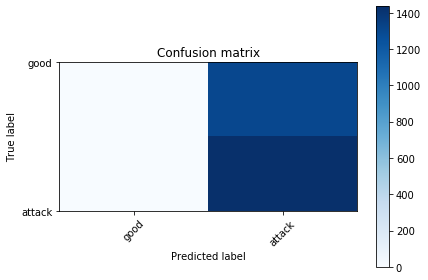

C:\Users\Psych\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1305
           1       0.52      1.00      0.69      1435

    accuracy                           0.52      2740
   macro avg       0.26      0.50      0.34      2740
weighted avg       0.27      0.52      0.36      2740



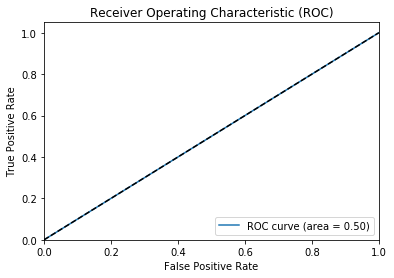

Fully connected neural network
Activation: relu Number of layers:  5 Number of neurons: 50 Optimizer: sgd
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 2s - loss: 4.4682 - val_loss: 0.2420
Epoch 2/1000
8217/8217 - 2s - loss: 0.1166 - val_loss: 0.0691
Epoch 3/1000
8217/8217 - 2s - loss: 0.0489 - val_loss: 0.0452
Epoch 4/1000
8217/8217 - 2s - loss: 0.0349 - val_loss: 0.0319
Epoch 5/1000
8217/8217 - 2s - loss: 0.0292 - val_loss: 0.0273
Epoch 6/1000
8217/8217 - 2s - loss: 0.0266 - val_loss: 0.0266
Epoch 7/1000
8217/8217 - 3s - loss: 0.0249 - val_loss: 0.0248
Epoch 8/1000
8217/8217 - 2s - loss: 0.0245 - val_loss: 0.0264
Epoch 9/1000
8217/8217 - 3s - loss: 0.0228 - val_loss: 0.0236
Epoch 10/1000
8217/8217 - 2s - loss: 0.0216 - val_loss: 0.0237
Epoch 11/1000
8217/8217 - 2s - loss: 0.0210 - val_loss: 0.0224
Epoch 12/1000
8217/8217 - 2s - loss: 0.0205 - val_loss: 0.0236
Epoch 13/1000
8217/8217 - 2s - loss: 0.0202 - val_loss: 0.0235
Epoch 00013: early stopping
[[9.9979

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


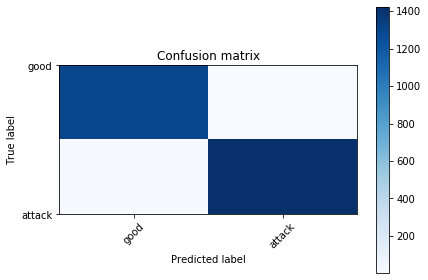

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1305
           1       1.00      0.99      0.99      1435

    accuracy                           0.99      2740
   macro avg       0.99      0.99      0.99      2740
weighted avg       0.99      0.99      0.99      2740



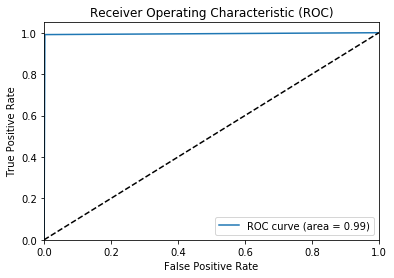

Fully connected neural network
Activation: sigmoid Number of layers:  5 Number of neurons: 50 Optimizer: sgd
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 2s - loss: 5.8164 - val_loss: 1.6467
Epoch 2/1000
8217/8217 - 2s - loss: 0.9316 - val_loss: 0.7639
Epoch 3/1000
8217/8217 - 2s - loss: 0.7398 - val_loss: 0.7258
Epoch 4/1000
8217/8217 - 2s - loss: 0.7186 - val_loss: 0.7138
Epoch 5/1000
8217/8217 - 2s - loss: 0.7101 - val_loss: 0.7083
Epoch 6/1000
8217/8217 - 2s - loss: 0.7054 - val_loss: 0.7048
Epoch 7/1000
8217/8217 - 2s - loss: 0.7031 - val_loss: 0.7026
Epoch 8/1000
8217/8217 - 2s - loss: 0.7013 - val_loss: 0.7016
Epoch 9/1000
8217/8217 - 2s - loss: 0.6997 - val_loss: 0.7009
Epoch 10/1000
8217/8217 - 2s - loss: 0.6989 - val_loss: 0.6989
Epoch 11/1000
8217/8217 - 2s - loss: 0.6982 - val_loss: 0.6982
Epoch 12/1000
8217/8217 - 2s - loss: 0.6974 - val_loss: 0.6981
Epoch 00012: early stopping
[[4.5695212e-01 5.3744656e-01 6.3669535e-07 ... 6.8059830e-07
  6.86

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


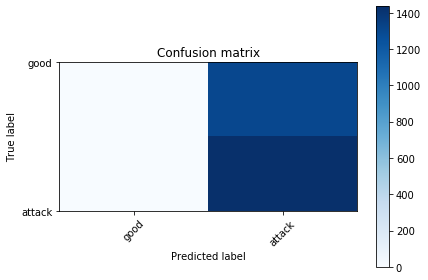

C:\Users\Psych\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1305
           1       0.52      1.00      0.69      1435

    accuracy                           0.52      2740
   macro avg       0.26      0.50      0.34      2740
weighted avg       0.27      0.52      0.36      2740



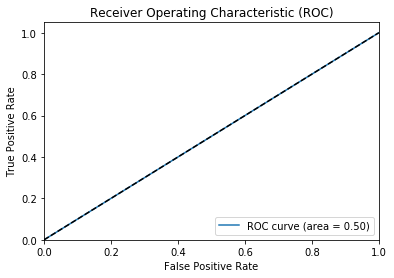

Fully connected neural network
Activation: tanh Number of layers:  5 Number of neurons: 50 Optimizer: sgd
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 2s - loss: 5.8279 - val_loss: 1.1332
Epoch 2/1000
8217/8217 - 2s - loss: 0.3611 - val_loss: 0.1735
Epoch 3/1000
8217/8217 - 2s - loss: 0.1335 - val_loss: 0.1233
Epoch 4/1000
8217/8217 - 2s - loss: 0.1002 - val_loss: 0.0920
Epoch 5/1000
8217/8217 - 2s - loss: 0.0779 - val_loss: 0.0692
Epoch 6/1000
8217/8217 - 2s - loss: 0.0611 - val_loss: 0.0526
Epoch 7/1000
8217/8217 - 2s - loss: 0.0482 - val_loss: 0.0454
Epoch 8/1000
8217/8217 - 2s - loss: 0.0408 - val_loss: 0.0391
Epoch 9/1000
8217/8217 - 2s - loss: 0.0361 - val_loss: 0.0354
Epoch 10/1000
8217/8217 - 2s - loss: 0.0325 - val_loss: 0.0330
Epoch 11/1000
8217/8217 - 2s - loss: 0.0300 - val_loss: 0.0311
Epoch 12/1000
8217/8217 - 2s - loss: 0.0276 - val_loss: 0.0296
Epoch 13/1000
8217/8217 - 2s - loss: 0.0258 - val_loss: 0.0284
Epoch 14/1000
8217/8217 - 2s - loss:

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


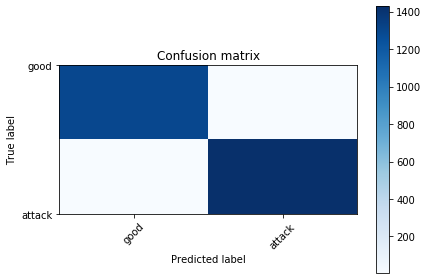

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1305
           1       1.00      1.00      1.00      1435

    accuracy                           1.00      2740
   macro avg       1.00      1.00      1.00      2740
weighted avg       1.00      1.00      1.00      2740



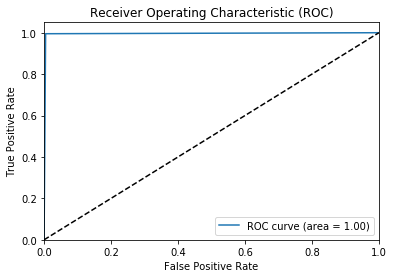

Fully connected neural network
Activation: relu Number of layers:  4 Number of neurons: 250 Optimizer: adam
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 3s - loss: 0.7079 - val_loss: 0.0225
Epoch 2/1000
8217/8217 - 3s - loss: 0.0214 - val_loss: 0.0231
Epoch 3/1000
8217/8217 - 3s - loss: 0.0253 - val_loss: 0.0217
Epoch 00003: early stopping
[[9.9930012e-01 6.9983047e-04 1.8714465e-13 ... 1.1534269e-13
  2.1467459e-13 1.1509348e-13]
 [9.5703423e-01 4.2965110e-02 1.9217232e-10 ... 7.9573612e-11
  1.6081059e-10 9.6048544e-11]
 [4.1253318e-07 9.9999964e-01 2.8452855e-19 ... 3.6431445e-21
  2.3948179e-20 1.7063036e-20]
 ...
 [9.9933785e-01 6.6218100e-04 1.3282135e-13 ... 8.0875234e-14
  1.5201581e-13 8.0781492e-14]
 [3.5565679e-06 9.9999642e-01 3.8904600e-17 ... 8.3533904e-19
  4.4243025e-18 3.2279001e-18]
 [1.8753790e-06 9.9999809e-01 1.0601230e-17 ... 1.9931956e-19
  1.1199944e-18 8.0753916e-19]]
[0 0 1 ... 0 1 1]
[0 0 1 ... 0 1 1]
[[1292   13]
 [   6 1429]]


C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


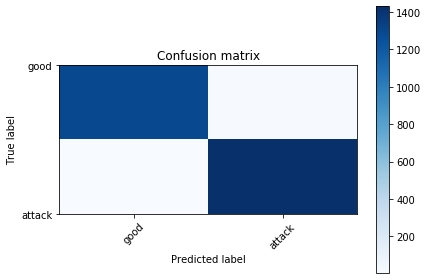

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1305
           1       0.99      1.00      0.99      1435

    accuracy                           0.99      2740
   macro avg       0.99      0.99      0.99      2740
weighted avg       0.99      0.99      0.99      2740



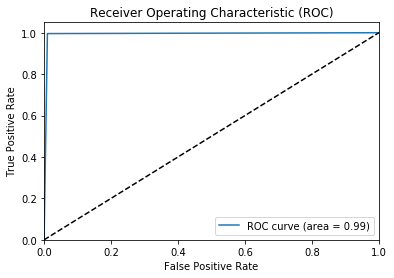

Fully connected neural network
Activation: sigmoid Number of layers:  4 Number of neurons: 250 Optimizer: adam
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 3s - loss: 1.6089 - val_loss: 0.7029
Epoch 2/1000
8217/8217 - 3s - loss: 0.6992 - val_loss: 0.6958
Epoch 3/1000
8217/8217 - 3s - loss: 0.6962 - val_loss: 0.6949
Epoch 4/1000
8217/8217 - 3s - loss: 0.6887 - val_loss: 0.6323
Epoch 5/1000
8217/8217 - 3s - loss: 0.3093 - val_loss: 0.1221
Epoch 6/1000
8217/8217 - 3s - loss: 0.0905 - val_loss: 0.0957
Epoch 7/1000
8217/8217 - 3s - loss: 0.0760 - val_loss: 0.0887
Epoch 8/1000
8217/8217 - 3s - loss: 0.0604 - val_loss: 0.0486
Epoch 9/1000
8217/8217 - 4s - loss: 0.0267 - val_loss: 0.0307
Epoch 10/1000
8217/8217 - 4s - loss: 0.0219 - val_loss: 0.0281
Epoch 11/1000
8217/8217 - 4s - loss: 0.0194 - val_loss: 0.0282
Epoch 12/1000
8217/8217 - 3s - loss: 0.0181 - val_loss: 0.0264
Epoch 13/1000
8217/8217 - 3s - loss: 0.0178 - val_loss: 0.0245
Epoch 14/1000
8217/8217 - 3s - 

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


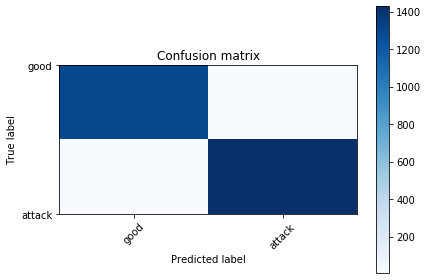

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1305
           1       0.99      1.00      0.99      1435

    accuracy                           0.99      2740
   macro avg       0.99      0.99      0.99      2740
weighted avg       0.99      0.99      0.99      2740



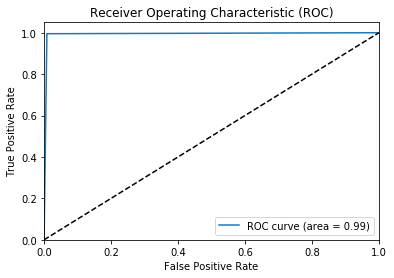

Fully connected neural network
Activation: tanh Number of layers:  4 Number of neurons: 250 Optimizer: adam
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 4s - loss: 1.3404 - val_loss: 0.0604
Epoch 2/1000
8217/8217 - 3s - loss: 0.0352 - val_loss: 0.0297
Epoch 3/1000
8217/8217 - 3s - loss: 0.0257 - val_loss: 0.0249
Epoch 4/1000
8217/8217 - 4s - loss: 0.0179 - val_loss: 0.0267
Epoch 5/1000
8217/8217 - 4s - loss: 0.0176 - val_loss: 0.0246
Epoch 00005: early stopping
[[9.98586774e-01 1.86081132e-04 1.83586650e-07 ... 1.32758530e-07
  1.53639220e-07 1.33624923e-07]
 [9.98151362e-01 3.96056508e-04 2.07261124e-07 ... 1.55182576e-07
  1.80502653e-07 1.56665408e-07]
 [5.04417549e-05 9.98852730e-01 1.61828623e-07 ... 1.17847407e-07
  1.37295004e-07 1.18773507e-07]
 ...
 [9.98584867e-01 1.87095065e-04 1.83592604e-07 ... 1.32880004e-07
  1.53803128e-07 1.33796561e-07]
 [5.12681945e-05 9.98856306e-01 1.61134807e-07 ... 1.17305461e-07
  1.36639898e-07 1.18223014e-07]
 [5.07

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


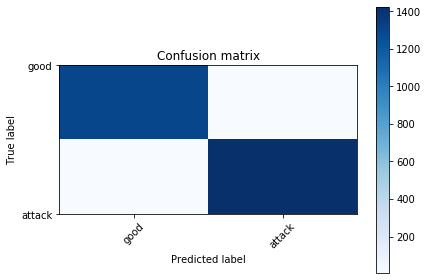

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1305
           1       1.00      0.99      0.99      1435

    accuracy                           0.99      2740
   macro avg       0.99      0.99      0.99      2740
weighted avg       0.99      0.99      0.99      2740



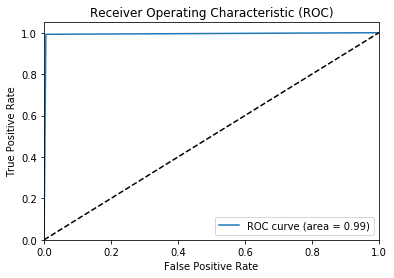

Fully connected neural network
Activation: relu Number of layers:  4 Number of neurons: 250 Optimizer: sgd
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 4s - loss: 2.3723 - val_loss: 0.0766
Epoch 2/1000
8217/8217 - 3s - loss: 0.0573 - val_loss: 0.0437
Epoch 3/1000
8217/8217 - 3s - loss: 0.0376 - val_loss: 0.0315
Epoch 4/1000
8217/8217 - 3s - loss: 0.0304 - val_loss: 0.0293
Epoch 5/1000
8217/8217 - 3s - loss: 0.0267 - val_loss: 0.0258
Epoch 6/1000
8217/8217 - 3s - loss: 0.0267 - val_loss: 0.0243
Epoch 7/1000
8217/8217 - 3s - loss: 0.0245 - val_loss: 0.0240
Epoch 8/1000
8217/8217 - 3s - loss: 0.0235 - val_loss: 0.0223
Epoch 9/1000
8217/8217 - 3s - loss: 0.0214 - val_loss: 0.0217
Epoch 10/1000
8217/8217 - 3s - loss: 0.0210 - val_loss: 0.0224
Epoch 00010: early stopping
[[9.9963522e-01 3.4381091e-04 3.3266185e-09 ... 3.3223193e-09
  2.1110376e-09 1.7640871e-09]
 [9.6370339e-01 3.6273792e-02 3.5394283e-09 ... 3.5423460e-09
  2.2280398e-09 1.8140044e-09]
 [2.172013

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


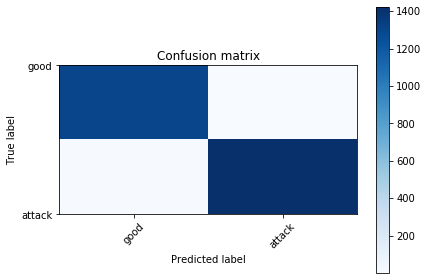

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1305
           1       1.00      0.99      0.99      1435

    accuracy                           0.99      2740
   macro avg       0.99      0.99      0.99      2740
weighted avg       0.99      0.99      0.99      2740



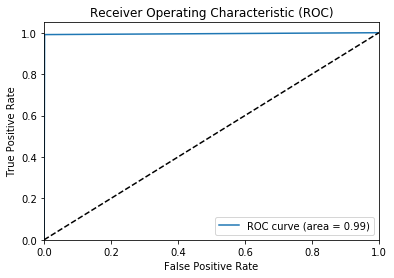

Fully connected neural network
Activation: sigmoid Number of layers:  4 Number of neurons: 250 Optimizer: sgd
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 3s - loss: 1.7922 - val_loss: 0.7179
Epoch 2/1000
8217/8217 - 3s - loss: 0.7053 - val_loss: 0.6999
Epoch 3/1000
8217/8217 - 3s - loss: 0.6978 - val_loss: 0.6954
Epoch 4/1000
8217/8217 - 3s - loss: 0.6947 - val_loss: 0.6951
Epoch 5/1000
8217/8217 - 3s - loss: 0.6911 - val_loss: 0.6899
Epoch 6/1000
8217/8217 - 3s - loss: 0.6896 - val_loss: 0.6873
Epoch 7/1000
8217/8217 - 3s - loss: 0.6872 - val_loss: 0.6846
Epoch 8/1000
8217/8217 - 3s - loss: 0.6833 - val_loss: 0.6819
Epoch 9/1000
8217/8217 - 3s - loss: 0.6780 - val_loss: 0.6746
Epoch 10/1000
8217/8217 - 3s - loss: 0.6696 - val_loss: 0.6638
Epoch 11/1000
8217/8217 - 3s - loss: 0.6578 - val_loss: 0.6485
Epoch 12/1000
8217/8217 - 3s - loss: 0.6378 - val_loss: 0.6222
Epoch 13/1000
8217/8217 - 3s - loss: 0.6028 - val_loss: 0.5770
Epoch 14/1000
8217/8217 - 3s - l

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


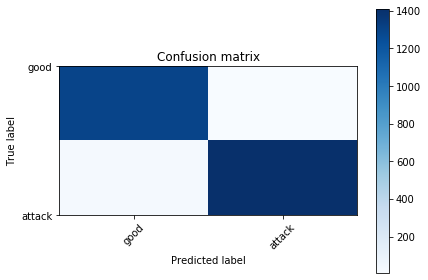

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1305
           1       0.99      0.98      0.99      1435

    accuracy                           0.99      2740
   macro avg       0.99      0.99      0.99      2740
weighted avg       0.99      0.99      0.99      2740



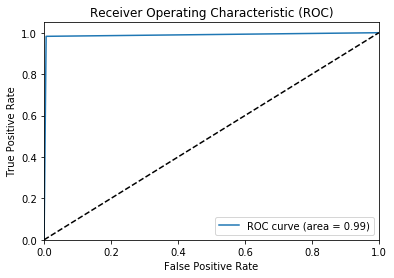

Fully connected neural network
Activation: tanh Number of layers:  4 Number of neurons: 250 Optimizer: sgd
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 4s - loss: 2.4201 - val_loss: 0.5505
Epoch 2/1000
8217/8217 - 3s - loss: 0.4771 - val_loss: 0.5053
Epoch 3/1000
8217/8217 - 4s - loss: 0.4403 - val_loss: 0.4792
Epoch 4/1000
8217/8217 - 3s - loss: 0.4151 - val_loss: 0.4553
Epoch 5/1000
8217/8217 - 3s - loss: 0.3966 - val_loss: 0.4369
Epoch 6/1000
8217/8217 - 3s - loss: 0.3732 - val_loss: 0.3205
Epoch 7/1000
8217/8217 - 3s - loss: 0.1518 - val_loss: 0.0828
Epoch 8/1000
8217/8217 - 3s - loss: 0.0712 - val_loss: 0.0562
Epoch 9/1000
8217/8217 - 4s - loss: 0.0494 - val_loss: 0.0471
Epoch 10/1000
8217/8217 - 3s - loss: 0.0401 - val_loss: 0.0407
Epoch 11/1000
8217/8217 - 4s - loss: 0.0337 - val_loss: 0.0381
Epoch 12/1000
8217/8217 - 3s - loss: 0.0304 - val_loss: 0.0347
Epoch 13/1000
8217/8217 - 3s - loss: 0.0276 - val_loss: 0.0328
Epoch 14/1000
8217/8217 - 3s - loss

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


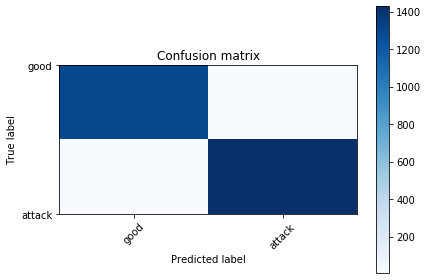

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1305
           1       0.99      1.00      0.99      1435

    accuracy                           0.99      2740
   macro avg       0.99      0.99      0.99      2740
weighted avg       0.99      0.99      0.99      2740



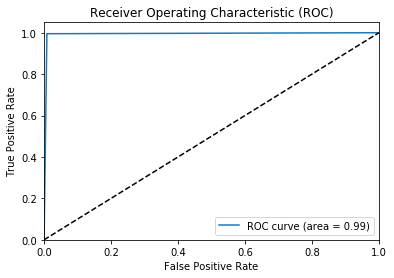

Fully connected neural network
Activation: relu Number of layers:  5 Number of neurons: 250 Optimizer: adam
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 4s - loss: 0.6652 - val_loss: 0.0224
Epoch 2/1000
8217/8217 - 3s - loss: 0.0250 - val_loss: 0.0351
Epoch 3/1000
8217/8217 - 4s - loss: 0.0262 - val_loss: 0.0219
Epoch 00003: early stopping
[[9.9987078e-01 1.2920174e-04 6.1226358e-16 ... 1.0724384e-16
  2.4282452e-16 9.3777671e-17]
 [9.9431747e-01 5.6825601e-03 5.7493038e-12 ... 1.5616152e-12
  2.3978187e-12 1.8386538e-12]
 [4.7514436e-06 9.9999523e-01 9.6078174e-28 ... 5.4692534e-29
  1.2140365e-28 9.4659803e-27]
 ...
 [9.9987113e-01 1.2879164e-04 5.6423316e-16 ... 9.8229465e-17
  2.2284031e-16 8.6488364e-17]
 [4.8069443e-05 9.9995196e-01 4.8782698e-23 ... 4.5242415e-24
  8.6748494e-24 3.0753504e-22]
 [1.7515313e-05 9.9998248e-01 2.4011190e-25 ... 1.7761490e-26
  3.6182400e-26 1.8346510e-24]]
[0 0 1 ... 0 1 1]
[0 0 1 ... 0 1 1]
[[1303    2]
 [  11 1424]]


C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


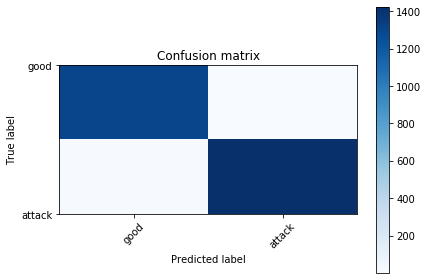

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1305
           1       1.00      0.99      1.00      1435

    accuracy                           1.00      2740
   macro avg       1.00      1.00      1.00      2740
weighted avg       1.00      1.00      1.00      2740



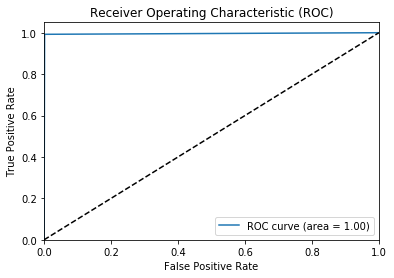

Fully connected neural network
Activation: sigmoid Number of layers:  5 Number of neurons: 250 Optimizer: adam
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 4s - loss: 1.8997 - val_loss: 0.7097
Epoch 2/1000
8217/8217 - 3s - loss: 0.7028 - val_loss: 0.7009
Epoch 3/1000
8217/8217 - 3s - loss: 0.6969 - val_loss: 0.7052
Epoch 4/1000
8217/8217 - 3s - loss: 0.6956 - val_loss: 0.6947
Epoch 5/1000
8217/8217 - 4s - loss: 0.6942 - val_loss: 0.6935
Epoch 6/1000
8217/8217 - 3s - loss: 0.6968 - val_loss: 0.6936
Epoch 7/1000
8217/8217 - 3s - loss: 0.6940 - val_loss: 0.6955
Epoch 00007: early stopping
[[4.41566348e-01 5.57547152e-01 1.09280364e-07 ... 1.08248408e-07
  1.03561916e-07 1.06951873e-07]
 [4.41566110e-01 5.57547390e-01 1.09281245e-07 ... 1.08249175e-07
  1.03562648e-07 1.06952633e-07]
 [4.41565901e-01 5.57547629e-01 1.09279732e-07 ... 1.08247470e-07
  1.03561014e-07 1.06951148e-07]
 ...
 [4.41566616e-01 5.57546914e-01 1.09280215e-07 ... 1.08248258e-07
  1.0356186

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


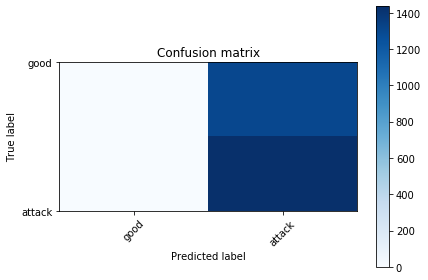

C:\Users\Psych\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1305
           1       0.52      1.00      0.69      1435

    accuracy                           0.52      2740
   macro avg       0.26      0.50      0.34      2740
weighted avg       0.27      0.52      0.36      2740



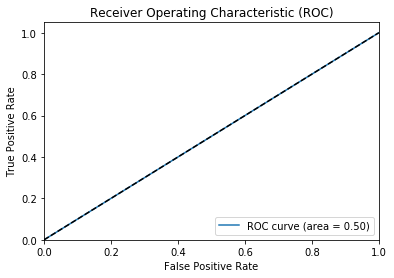

Fully connected neural network
Activation: tanh Number of layers:  5 Number of neurons: 250 Optimizer: adam
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 4s - loss: 1.5548 - val_loss: 0.0567
Epoch 2/1000
8217/8217 - 3s - loss: 0.0457 - val_loss: 0.0432
Epoch 3/1000
8217/8217 - 3s - loss: 0.0274 - val_loss: 0.0255
Epoch 4/1000
8217/8217 - 3s - loss: 0.0211 - val_loss: 0.0334
Epoch 5/1000
8217/8217 - 3s - loss: 0.0226 - val_loss: 0.0242
Epoch 6/1000
8217/8217 - 4s - loss: 0.0197 - val_loss: 0.0250
Epoch 7/1000
8217/8217 - 3s - loss: 0.0166 - val_loss: 0.0213
Epoch 8/1000
8217/8217 - 3s - loss: 0.0154 - val_loss: 0.0267
Epoch 9/1000
8217/8217 - 3s - loss: 0.0141 - val_loss: 0.0231
Epoch 00009: early stopping
[[9.9845016e-01 8.2217751e-04 8.2292431e-08 ... 8.6843563e-08
  8.7234852e-08 8.7394234e-08]
 [9.9844068e-01 8.2730572e-04 8.2876660e-08 ... 8.7474454e-08
  8.7920895e-08 8.8122199e-08]
 [4.5125021e-04 9.9881220e-01 8.3341597e-08 ... 8.6605382e-08
  8.731843

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


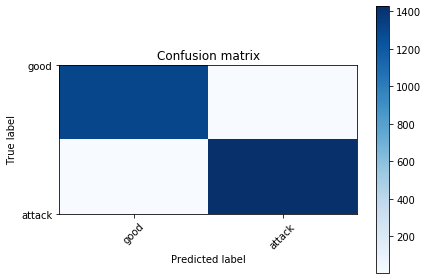

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1305
           1       1.00      0.99      0.99      1435

    accuracy                           0.99      2740
   macro avg       0.99      0.99      0.99      2740
weighted avg       0.99      0.99      0.99      2740



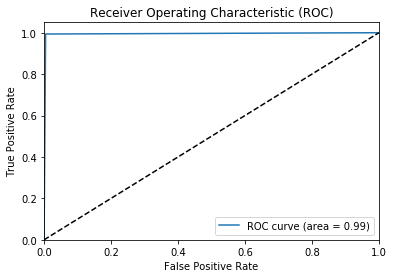

Fully connected neural network
Activation: relu Number of layers:  5 Number of neurons: 250 Optimizer: sgd
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 3s - loss: 2.7253 - val_loss: 0.0719
Epoch 2/1000
8217/8217 - 3s - loss: 0.0523 - val_loss: 0.0363
Epoch 3/1000
8217/8217 - 3s - loss: 0.0343 - val_loss: 0.0278
Epoch 4/1000
8217/8217 - 3s - loss: 0.0294 - val_loss: 0.0273
Epoch 5/1000
8217/8217 - 3s - loss: 0.0254 - val_loss: 0.0232
Epoch 6/1000
8217/8217 - 4s - loss: 0.0271 - val_loss: 0.0223
Epoch 7/1000
8217/8217 - 4s - loss: 0.0235 - val_loss: 0.0221
Epoch 8/1000
8217/8217 - 4s - loss: 0.0224 - val_loss: 0.0217
Epoch 9/1000
8217/8217 - 4s - loss: 0.0215 - val_loss: 0.0207
Epoch 10/1000
8217/8217 - 4s - loss: 0.0207 - val_loss: 0.0206
Epoch 11/1000
8217/8217 - 3s - loss: 0.0184 - val_loss: 0.0196
Epoch 12/1000
8217/8217 - 3s - loss: 0.0221 - val_loss: 0.0194
Epoch 13/1000
8217/8217 - 3s - loss: 0.0181 - val_loss: 0.0190
Epoch 00013: early stopping
[[9.995

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


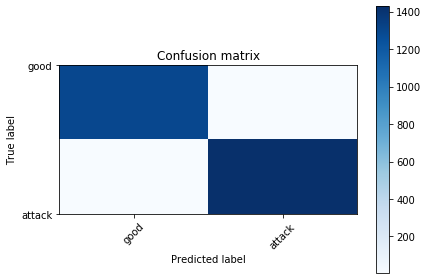

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1305
           1       1.00      1.00      1.00      1435

    accuracy                           1.00      2740
   macro avg       1.00      1.00      1.00      2740
weighted avg       1.00      1.00      1.00      2740



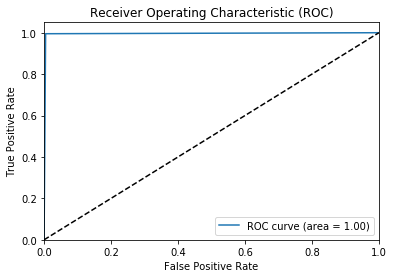

Fully connected neural network
Activation: sigmoid Number of layers:  5 Number of neurons: 250 Optimizer: sgd
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 3s - loss: 2.1126 - val_loss: 0.7201
Epoch 2/1000
8217/8217 - 3s - loss: 0.7089 - val_loss: 0.7026
Epoch 3/1000
8217/8217 - 3s - loss: 0.7009 - val_loss: 0.6988
Epoch 4/1000
8217/8217 - 3s - loss: 0.6980 - val_loss: 0.7066
Epoch 5/1000
8217/8217 - 3s - loss: 0.6965 - val_loss: 0.6995
Epoch 00005: early stopping
[[5.1939142e-01 4.7697410e-01 4.8810870e-07 ... 5.3151871e-07
  5.3459888e-07 3.7828170e-07]
 [5.1938403e-01 4.7698322e-01 4.8782067e-07 ... 5.3122687e-07
  5.3416471e-07 3.7794925e-07]
 [5.1919323e-01 4.7718966e-01 4.8550737e-07 ... 5.2895996e-07
  5.3192480e-07 3.7643329e-07]
 ...
 [5.1938111e-01 4.7698462e-01 4.8810364e-07 ... 5.3152593e-07
  5.3457296e-07 3.7828210e-07]
 [5.1918119e-01 4.7719455e-01 4.8657193e-07 ... 5.3002674e-07
  5.3294877e-07 3.7721230e-07]
 [5.1922077e-01 4.7715721e-01 4.86

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


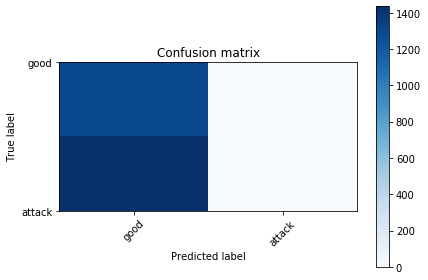

              precision    recall  f1-score   support

           0       0.48      1.00      0.65      1305
           1       0.00      0.00      0.00      1435

    accuracy                           0.48      2740
   macro avg       0.24      0.50      0.32      2740
weighted avg       0.23      0.48      0.31      2740



C:\Users\Psych\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


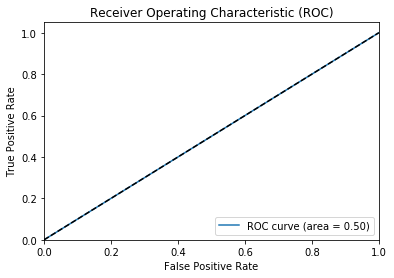

Fully connected neural network
Activation: tanh Number of layers:  5 Number of neurons: 250 Optimizer: sgd
Train on 8217 samples, validate on 2740 samples
Epoch 1/1000
8217/8217 - 4s - loss: 2.3154 - val_loss: 0.1922
Epoch 2/1000
8217/8217 - 4s - loss: 0.1136 - val_loss: 0.0726
Epoch 3/1000
8217/8217 - 3s - loss: 0.0571 - val_loss: 0.0489
Epoch 4/1000
8217/8217 - 4s - loss: 0.0397 - val_loss: 0.0414
Epoch 5/1000
8217/8217 - 4s - loss: 0.0324 - val_loss: 0.0361
Epoch 6/1000
8217/8217 - 3s - loss: 0.0282 - val_loss: 0.0336
Epoch 7/1000
8217/8217 - 3s - loss: 0.0253 - val_loss: 0.0327
Epoch 8/1000
8217/8217 - 3s - loss: 0.0235 - val_loss: 0.0301
Epoch 9/1000
8217/8217 - 3s - loss: 0.0221 - val_loss: 0.0289
Epoch 10/1000
8217/8217 - 3s - loss: 0.0207 - val_loss: 0.0286
Epoch 11/1000
8217/8217 - 3s - loss: 0.0202 - val_loss: 0.0269
Epoch 12/1000
8217/8217 - 3s - loss: 0.0188 - val_loss: 0.0269
Epoch 13/1000
8217/8217 - 3s - loss: 0.0187 - val_loss: 0.0255
Epoch 14/1000
8217/8217 - 3s - loss

C:\Users\Psych\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


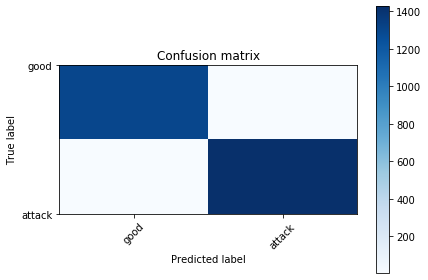

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1305
           1       1.00      0.99      1.00      1435

    accuracy                           1.00      2740
   macro avg       1.00      1.00      1.00      2740
weighted avg       1.00      1.00      1.00      2740



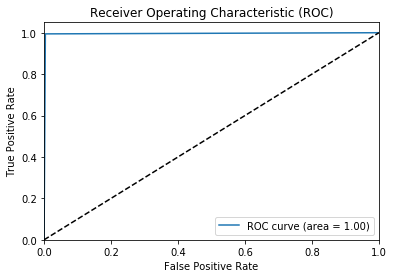

In [29]:
test_nn('relu',1,100,'adam',x_train,y_train,x_test,y_test)
test_nn('sigmoid',1,100,'adam',x_train,y_train,x_test,y_test)
test_nn('tanh',1,100,'adam',x_train,y_train,x_test,y_test)
#sgd
test_nn('relu',1,100,'sgd',x_train,y_train,x_test,y_test)
test_nn('sigmoid',1,100,'sgd',x_train,y_train,x_test,y_test)
test_nn('tanh',1,100,'sgd',x_train,y_train,x_test,y_test)
#layer count
test_nn('relu',2,100,'adam',x_train,y_train,x_test,y_test)
test_nn('sigmoid',2,100,'adam',x_train,y_train,x_test,y_test)
test_nn('tanh',2,100,'adam',x_train,y_train,x_test,y_test)
test_nn('relu',2,100,'sgd',x_train,y_train,x_test,y_test)
test_nn('sigmoid',2,100,'sgd',x_train,y_train,x_test,y_test)
test_nn('tanh',2,100,'sgd',x_train,y_train,x_test,y_test)
test_nn('relu',3,100,'adam',x_train,y_train,x_test,y_test)
test_nn('sigmoid',3,100,'adam',x_train,y_train,x_test,y_test)
test_nn('tanh',3,100,'adam',x_train,y_train,x_test,y_test)
test_nn('relu',3,100,'sgd',x_train,y_train,x_test,y_test)
test_nn('sigmoid',3,100,'sgd',x_train,y_train,x_test,y_test)
test_nn('tanh',3,100,'sgd',x_train,y_train,x_test,y_test)
#neron count
test_nn('relu',2,50,'adam',x_train,y_train,x_test,y_test)
test_nn('sigmoid',2,50,'adam',x_train,y_train,x_test,y_test)
test_nn('tanh',2,50,'adam',x_train,y_train,x_test,y_test)
test_nn('relu',2,50,'sgd',x_train,y_train,x_test,y_test)
test_nn('sigmoid',2,50,'sgd',x_train,y_train,x_test,y_test)
test_nn('tanh',2,50,'sgd',x_train,y_train,x_test,y_test)
test_nn('relu',3,50,'adam',x_train,y_train,x_test,y_test)
test_nn('sigmoid',3,50,'adam',x_train,y_train,x_test,y_test)
test_nn('tanh',3,50,'adam',x_train,y_train,x_test,y_test)
test_nn('relu',3,50,'sgd',x_train,y_train,x_test,y_test)
test_nn('sigmoid',3,50,'sgd',x_train,y_train,x_test,y_test)
test_nn('tanh',3,50,'sgd',x_train,y_train,x_test,y_test)
test_nn('relu',2,250,'adam',x_train,y_train,x_test,y_test)
test_nn('sigmoid',2,250,'adam',x_train,y_train,x_test,y_test)
test_nn('tanh',2,250,'adam',x_train,y_train,x_test,y_test)
test_nn('relu',2,250,'sgd',x_train,y_train,x_test,y_test)
test_nn('sigmoid',2,250,'sgd',x_train,y_train,x_test,y_test)
test_nn('tanh',2,250,'sgd',x_train,y_train,x_test,y_test)
test_nn('relu',3,250,'adam',x_train,y_train,x_test,y_test)
test_nn('sigmoid',3,250,'adam',x_train,y_train,x_test,y_test)
test_nn('tanh',3,250,'adam',x_train,y_train,x_test,y_test)
test_nn('relu',3,250,'sgd',x_train,y_train,x_test,y_test)
test_nn('sigmoid',3,250,'sgd',x_train,y_train,x_test,y_test)
test_nn('tanh',3,250,'sgd',x_train,y_train,x_test,y_test)



## Convuluted Neural Network
All of the same from Neural Network plus **kernal number** and **kernal size**

In [22]:
#prep data for cnn by treating as a 1 height image
img_data = x.values.reshape((x.shape[0], 1, x.shape[1], 1))
x_cnn_train, y_cnn_test, y_cnn_train, y_cnn_test = train_test_split(img_data, y_one_hot, test_size=0.25, random_state=42) 

print(x_cnn_train.shape)
print(y_cnn_train.shape)
print(x_cnn_test.shape)
print(y_cnn_test.shape)

def test_cnn(activation, num_layers, num_neurons, optimizer, num_kernals, _kernal_size, x_train,y_train,x_test,y_test):
     # define a CNN
    cnn = Sequential()
    for i in range(num_kernals):
        cnn.add(Conv2D(64, kernel_size=_kernal_size, strides=(1, 1), activation=activation, input_shape=x_test.shape[1:]))
        #cnn.add(Conv2D(64, kernel_size=_kernal_size, strides=(1, 1), activation=activation, input_shape=x_test.shape))
        cnn.add(MaxPooling2D(pool_size=2))

    #change to 1D output
    cnn.add(Flatten())

    current=num_neurons
    interval=num_neurons/(num_layers+1)
    for i in range(num_layers):
        current=current-interval
        cnn.add(Dense(current, activation=activation))
        cnn.add(Dropout(0.5))
    cnn.add(Dense(3, activation="softmax"))

    # define optimizer and objective, compile cnn

    cnn.compile(loss="categorical_crossentropy", optimizer=optimizer)
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')  
    cnn.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], verbose=2, epochs=1000)
    
    
    #test model
    pred = model.predict(x_test)
    test_model(y_test, pred)
    return model

(8217, 1, 104, 1)
(8217, 2)
(2740, 1, 104, 1)
(2740, 2)


In [24]:
def test_cnn(activation, num_layers, num_neurons, optimizer, num_kernals, _kernal_size, x_train,y_train,x_test,y_test):
    print("Convoluted neural network")
    print("Activation:",activation,"Number of layers: ",num_layers+2,"Number of neurons:",num_neurons,"Optimizer:",optimizer)

   # Build network
    model = Sequential()
    for i in range(num_kernals):
        model.add(Conv2D(64, kernel_size=_kernal_size, strides=(1, 1), activation=activation, input_shape=x_test.shape[1:]))
        #cnn.add(Conv2D(64, kernel_size=_kernal_size, strides=(1, 1), activation=activation, input_shape=x_test.shape))
        model.add(MaxPooling2D(pool_size=2))
        

    #change to 1D output
    cnn.add(Flatten())
        
        
    model.add(Dense(num_neurons, input_dim=x_train.shape[1], activation=activation))
    #model.add(Dense(num_neurons, input_dim=2, activation=activation))
    current=num_neurons
    interval=num_neurons/(num_layers+1)
    for i in range(num_layers):
        current=current-interval
        model.add(Dense(current, activation=activation))
        
    model.add(Dense(y_train.size, activation='softmax'))
        
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')  
    #model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], verbose=2, epochs=1000)
    
    #test model
    pred = model.predict(x_test)
    print(pred)
    test_model(y_test, pred)
    
    



In [26]:
cnn = Sequential()
cnn.add(Conv2D(64, kernel_size=(1, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=(x_cnn_train.shape[1:])))

# the above code is equivalent to 
# model.add(Conv1D(64, kernel_size=3, strides=1, activation='relu', input_shape=(128, 1)))

cnn.add(MaxPooling2D(pool_size=(1,2)))

cnn.add(Conv2D(128, kernel_size=(1, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=(x_cnn_train.shape[1:])))
cnn.add(MaxPooling2D(pool_size=(1,2)))
    
    
cnn.add(Flatten())
cnn.add(Dense(1024, activation="relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(3, activation="softmax"))

# define optimizer and objective, compile cnn

cnn.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
#monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')  
#cnn.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], verbose=2, epochs=1000)
cnn.fit(x_cnn_train, y_cnn_train, validation_data=(x_cnn_test,y_cnn_test), verbose=2, epochs=10)
    

pred = cnn.predict(x_cnn_test)

test_model(y_cnn_test, pred)

Train on 8217 samples, validate on 2740 samples
Epoch 1/10


InvalidArgumentError:  logits and labels must have the same first dimension, got logits shape [32,3] and labels shape [64]
	 [[node loss/dense_20_loss/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at C:\Users\Psych\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]] [Op:__inference_distributed_function_14150]

Function call stack:
distributed_function


In [115]:
np.argmax(pred, axis=1)
score = metrics.accuracy_score(y_test, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_test, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_test, pred))

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [25]:
test_cnn('relu',1,100,'adam',2,3,x_cnn_train,y_cnn_train,x_cnn_test,y_cnn_test)

Convoluted neural network
Activation: relu Number of layers:  3 Number of neurons: 100 Optimizer: adam


ValueError: Negative dimension size caused by subtracting 3 from 1 for 'conv2d_18/Conv2D' (op: 'Conv2D') with input shapes: [?,1,104,1], [3,3,1,64].